In [49]:
import numpy as np
from batchcreator import DataGenerator, undo_prep
from model_builder import GAN
import tensorflow as tf
from validation import Evaluator
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
list_IDs = np.load('datasets/val2019_3y_30m.npy', allow_pickle = True)
print(list_IDs[-1])
print(len(list_IDs))

gen = DataGenerator(list_IDs, batch_size=1, x_seq_size=6, 
                                       y_seq_size=3, norm_method='minmax', load_prep=True,
                         downscale256 = True, convert_to_dbz = True, 
                              y_is_rtcor = True, shuffle=False)


cp_gen = DataGenerator(gen.list_IDs, batch_size=gen.batch_size, x_seq_size=gen.inp_shape[0], 
                                       y_seq_size=gen.out_shape[0], norm_method=None, load_prep=False,
                         downscale256 = False, convert_to_dbz = False, 
                              y_is_rtcor = gen.y_is_rtcor, shuffle=False, crop_y=False)

[list(['201912301135', '201912301140', '201912301145', '201912301150', '201912301155', '201912301200'])
 list(['201912301230', '201912301300', '201912301330'])]
6570


In [170]:
from model_builder import GAN
x_length = 6
y_length = 3

gan = GAN(rnn_type='GRU', x_length=x_length, 
            y_length=y_length, architecture='AENN', relu_alpha=.2,
           l_adv = 0.006, l_rec = 1, g_cycles=3, label_smoothing=0.2
            , norm_method = 'minmax', downscale256 = True, rec_with_mae= False,
           r_to_dbz = True, batch_norm = False)

model = gan.generator
model.load_weights('saved_models/model_quiet_yogurt_535')


0it [00:00, ?it/s]

[list(['201912301135', '201912301140', '201912301145', '201912301150', '201912301155', '201912301200'])
 list(['201912301230', '201912301300', '201912301330'])]
6570


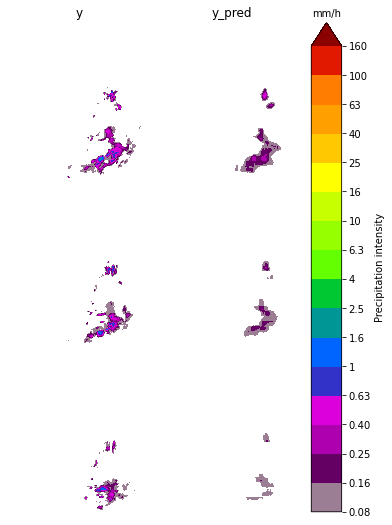

1it [00:00,  1.83it/s]

1


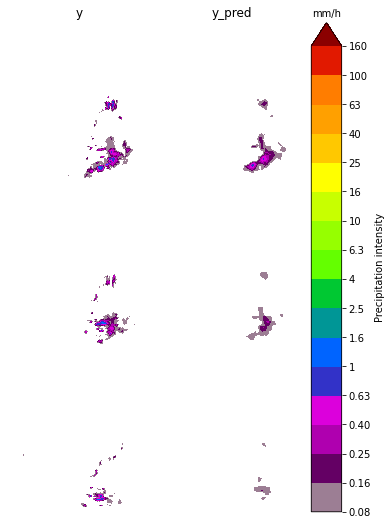

2it [00:01,  1.84it/s]

2


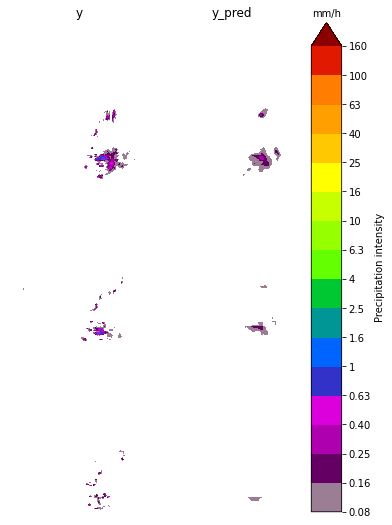

3it [00:01,  1.84it/s]

3


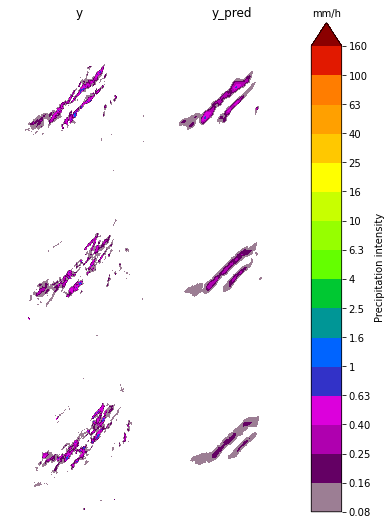

4it [00:02,  1.61it/s]

4


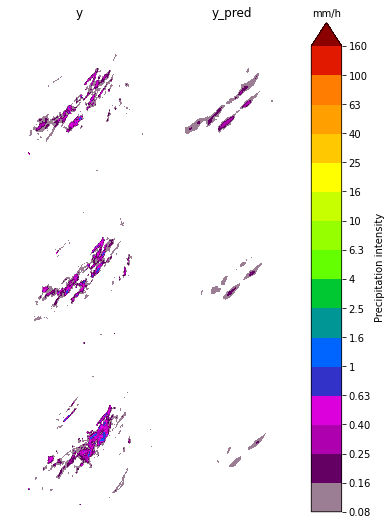

5it [00:02,  1.69it/s]

5


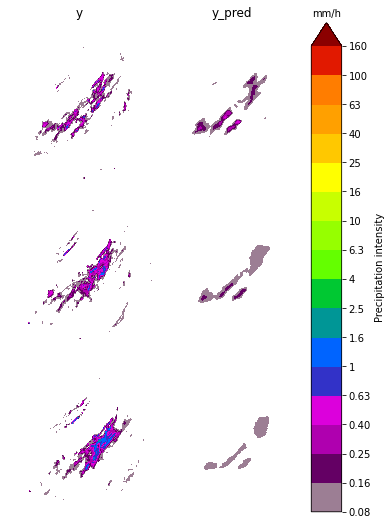

5it [00:03,  1.44it/s]

6


In [174]:
c = 0
list_IDs = np.load('datasets/val2019_3y_30m.npy', allow_pickle = True)
print(list_IDs[-1])
print(len(list_IDs))

gen = DataGenerator(list_IDs, batch_size=1, x_seq_size=6, 
                                       y_seq_size=3, norm_method='minmax', load_prep=True,
                         downscale256 = True, convert_to_dbz = True, 
                              y_is_rtcor = True, shuffle=False)


cp_gen = DataGenerator(gen.list_IDs, batch_size=gen.batch_size, x_seq_size=gen.inp_shape[0], 
                                       y_seq_size=gen.out_shape[0], norm_method=None, load_prep=False,
                         downscale256 = False, convert_to_dbz = False, 
                              y_is_rtcor = gen.y_is_rtcor, shuffle=False, crop_y=False)

for (xs_prep, ys_prep), (_, ys) in tqdm(zip(gen, cp_gen)):

    ys_pred = model.predict(xs_prep)        
    ys_pred = undo_prep(ys_pred)
    
    
    for y_pred, y_target in zip(ys_pred, ys):
        leadtimes = [30, 60, 90]          
        plot_target_pred(y_target, y_pred)
        plt.show()
    c+=1
    print(c)
    if c>5:
        break

In [25]:
np.load('results/n_sample_SPROG_val_masked.npy')

array(6570.)

In [26]:
np.load('results/n_sample_ANVIL_val_masked.npy')

array(5967.)

In [72]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_val_masked')
evaluator.load_accum_scores()
cat = evaluator.cat_dicts
cat.shape

(3, 4)

In [ ]:
det_cont_fct_merge(cat[0,0], )

In [ ]:
            cat_score = det_cat_fct_compute(self.cat_dicts[i,j], scores = ['POD', 'CSI', 'FAR', 'BIAS'])
            cat_score['threshold'] = thr
            cat_score['leadtime'] = lt

In [142]:
def get_scores_thr(evaluator):
    cat_dict_thrs = []
    cat_dicts = evaluator.cat_dicts
    # add threshold as key to the dicts
    for i, thr in enumerate(evaluator.thresholds):
        cat_dict_thr= pysteps.verification.detcatscores.det_cat_fct_init(thr)
        cat_dict_thr['hits'] = cat_dict_thr['false_alarms'] = cat_dict_thr['misses'] = cat_dict_thr['correct_negatives'] = 0
        for j, lt in enumerate(evaluator.leadtimes):
            cat_dict_thr = pysteps.verification.detcatscores.det_cat_fct_merge(cat_dict_thr, cat_dicts[j, i])
        cat_dict_thrs.append(cat_dict_thr)
        
    cat_scores = []
    # add threshold as key to the dicts
    for i, thr in enumerate(evaluator.thresholds):
            cat_score = pysteps.verification.detcatscores.det_cat_fct_compute(cat_dict_thrs[i], scores = ['POD', 'CSI', 'FAR', 'BIAS'])
            cat_score['threshold'] = thr
            cat_score['nowcast_method'] = 'S-PROG'
            cat_scores.append(cat_score)
    return cat_scores

In [143]:
import pysteps
a = get_scores_thr(evaluator)

In [144]:
df = pd.DataFrame(a)
df.index = df['threshold']
df

POD       CSI       FAR       BIAS  threshold nowcast_method
threshold                                                                   
0.5        0.534087  0.342028  0.512523   1.095614        0.5         S-PROG
5.0        0.344071  0.097786  0.879809   2.862692        5.0         S-PROG
10.0       0.249679  0.034644  0.961330   6.456637       10.0         S-PROG
30.0       0.070825  0.000969  0.999018  72.135211       30.0         S-PROG

In [148]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_earthy_mountain_541_masked_val')
evaluator.load_accum_scores()
a = get_scores_thr(evaluator)
df = pd.DataFrame(a)
df.index = df['threshold']
df

POD       CSI       FAR        BIAS  threshold nowcast_method
threshold                                                                    
0.5        0.637885  0.347968  0.566376    1.471055        0.5         S-PROG
5.0        0.358969  0.058817  0.934280    5.462076        5.0         S-PROG
10.0       0.183552  0.011599  0.987770   15.008071       10.0         S-PROG
30.0       0.018700  0.000116  0.999883  159.622440       30.0         S-PROG

In [150]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_quiet_yogurt_535_val')
evaluator.load_accum_scores()
a = get_scores_thr(evaluator)
df = pd.DataFrame(a)
df.index = df['threshold']
df

POD       CSI       FAR        BIAS  threshold nowcast_method
threshold                                                                    
0.5        0.704253  0.353794  0.584469    1.694825        0.5         S-PROG
5.0        0.580995  0.037337  0.961630   15.141851        5.0         S-PROG
10.0       0.460154  0.002752  0.997239  166.674771       10.0         S-PROG
30.0            NaN  0.000000  1.000000         inf       30.0         S-PROG

In [ ]:
import pysteps
a = get_scores_thr(evaluator)

In [146]:
print(df.to_latex)

<bound method NDFrame.to_latex of                 POD       CSI       FAR       BIAS  threshold nowcast_method
threshold                                                                   
0.5        0.534087  0.342028  0.512523   1.095614        0.5         S-PROG
5.0        0.344071  0.097786  0.879809   2.862692        5.0         S-PROG
10.0       0.249679  0.034644  0.961330   6.456637       10.0         S-PROG
30.0       0.070825  0.000969  0.999018  72.135211       30.0         S-PROG>


In [ ]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_val_masked')
evaluator.load_accum_scores()
scores_sprog = evaluator.get_scores()[0]
scores_sprog_cont = evaluator.get_scores()[1]
for dic in scores_sprog:
    dic['nowcast_method'] = 'S-PROG'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_earthy_mountain_541_masked_val')
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_quiet_yogurt_535_val')
evaluator.load_accum_scores()
scores_nag = evaluator.get_scores()[0]
scores_nag_cont = evaluator.get_scores()[1]
for dic in scores_nag:
    dic['nowcast_method'] = 'NAG'
    


In [32]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_val_bigdataset')
evaluator.load_accum_scores()
scores_sprog = evaluator.get_scores()[0]
scores_sprog_cont = evaluator.get_scores()[1]

evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'ANVIL_val_masked')
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]


for dic in scores_sprog:
    dic['nowcast_method'] = 'S-PROG'
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'

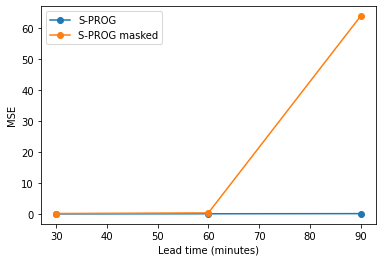

In [33]:
mse_sprog = [dic_lt['MSE'] for dic_lt in scores_sprog_cont]
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]
#mse_nag = [dic_lt['MSE'] for dic_lt in scores_nag_cont]

plt.plot([30,60,90], mse_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mse_gan, label = 'S-PROG masked', marker = 'o')
#plt.plot([30,60,90], mse_nag, label = 'NAG', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE')
plt.legend()

In [174]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_test')
evaluator.load_accum_scores()
scores_sprog = evaluator.get_scores()[0]
scores_sprog_cont = evaluator.get_scores()[1]
for dic in scores_sprog:
    dic['nowcast_method'] = 'S-PROG'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_easy_vortex_560_test')
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_quiet_yogurt_535_test')
evaluator.load_accum_scores()
scores_nag = evaluator.get_scores()[0]
scores_nag_cont = evaluator.get_scores()[1]
for dic in scores_nag:
    dic['nowcast_method'] = 'NAG'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'ANVIL_val_masked')
evaluator.load_accum_scores()
scores_anvil = evaluator.get_scores()[0]
scores_anvil_cont = evaluator.get_scores()[1]
for dic in scores_anvil:
    dic['nowcast_method'] = 'ANVIL'

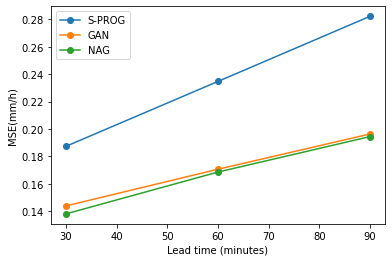

In [176]:
mse_sprog = [dic_lt['MSE'] for dic_lt in scores_sprog_cont]
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]
mse_nag = [dic_lt['MSE'] for dic_lt in scores_nag_cont]
mse_anvil = [dic_lt['MSE'] for dic_lt in scores_anvil_cont]

plt.plot([30,60,90], mse_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mse_gan, label = 'GAN', marker = 'o')
plt.plot([30,60,90], mse_nag, label = 'NAG', marker = 'o')
#plt.plot([30,60], mse_anvil[:-1], label = 'ANVIL', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE(mm/h)')
plt.legend()
#
plt.savefig('figures/results_MSE')

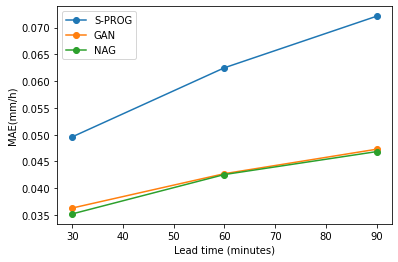

In [177]:
mae_sprog = [dic_lt['MAE'] for dic_lt in scores_sprog_cont]
mae_gan = [dic_lt['MAE'] for dic_lt in scores_gan_cont]
mae_nag = [dic_lt['MAE'] for dic_lt in scores_nag_cont]

plt.plot([30,60,90], mae_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mae_gan, label = 'GAN', marker = 'o')
plt.plot([30,60,90], mae_nag, label = 'NAG', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MAE(mm/h)')
plt.legend()
plt.savefig('figures/results_MAE')

In [58]:
def performance_diagram(cat_scores, legend=True):
    '''
    Plots a performance diagram. 
    The performance diagram visualizes multiple categorical metrics inside 1 figure.
    The y-axis show the POD (or recall) and the x-axis is 1-FAR (or precision). 
    Lines are drawn to indicate the CSI and the bias. 
    cat_scores: categorical scores calculated with the Evaluator class
    legend: shows a legend when true
    '''
    # plt.figure(figsize=(6,6))
    colors_lt = {30:'red', 60:'blue', 90:'black'}
    marker_size = 100
    for cat_score in cat_scores:
        if cat_score['nowcast_method'] == 'S-PROG':
            marker = '^' # triangle
        elif cat_score['nowcast_method'] == 'GAN':
            marker = 'o' # circle
        elif cat_score['nowcast_method'] == 'NAG':
            marker = 's' # square
        elif cat_score['nowcast_method'] == 'ANVIL':
            marker = 'x'
        plt.scatter(1-cat_score['FAR'], cat_score['POD'], 
                    label='{}, leadtime = {}'.format(cat_score['nowcast_method'],cat_score['leadtime']),
                    marker=marker, c=colors_lt[cat_score['leadtime']], s = marker_size)
    
    # Plot bias lines
    biases = [0.3, 0.5, 0.8, 1, 1.3, 1.5, 2, 3, 5, 10]
    for i in range(len(biases)):
        bias = biases[i]
        label = ""
        if i == 0:
            label = "Bias frequency"
        plt.plot([0, 1], [0, bias], 'k--', label=label, lw = 1, dashes=(5, 10))
        if bias <= 1:
            plt.text(1, bias, "%2.1f" % (bias))
        else:
            plt.text(1.0/bias, 1, "%2.1f" % (bias))
            
    # Plot threat score lines
    threats = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for i in range(len(threats)):
        threat = threats[i]
        x = np.linspace(threat, 1, 100)
        label = ""
        if i == 0:
            label = "Threat score"
        y = 1.0 / (1 + 1.0/threat - 1.0 / x)
        plt.plot(x, y, 'k-', label=label, lw = 1)
        xx = 2.0 / (1 + 1.0/threat)
        #plt.text(xx, xx, str(threat))
        plt.text(x[56], y[56], str(threat))
    plt.xlabel("Success ratio (1 - FAR)")
    plt.ylabel("Probability of detection")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1))

In [ ]:
def get_scores_thr(self):
    cat_scores = []
    # add threshold as key to the dicts
    for i, lt in enumerate(self.leadtimes):
        for j, thr in enumerate(self.thresholds):
            cat_score = det_cat_fct_compute(self.cat_dicts[i,j], scores = ['POD', 'CSI', 'FAR', 'BIAS'])
            cat_score['threshold'] = thr
            cat_score['leadtime'] = lt
            cat_scores.append(cat_score)

In [ ]:
thr_gan = [score for score in scores_gan if score['threshold']  == thr ]

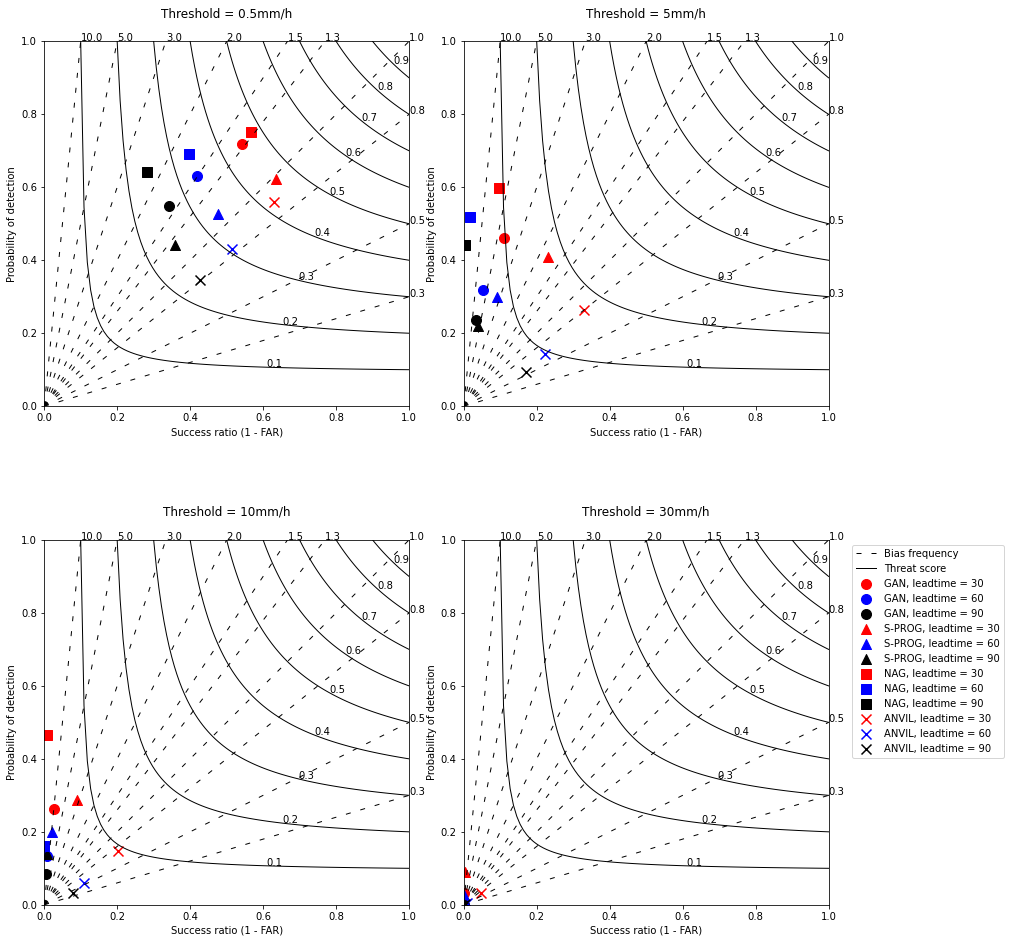

In [59]:
#from plotter import performance_diagram

plt.figure(figsize=(14,14))
for i,thr in enumerate(evaluator.thresholds):
    plt.subplot(2,2,i+1)
    thr_gan = [score for score in scores_gan if score['threshold']  == thr ]
    thr_sprog = [score for score in scores_sprog if score['threshold']  == thr]
    thr_nag = [score for score in scores_nag if score['threshold']  == thr]
    thr_anvil = [score for score in scores_anvil if score['threshold']  == thr]
    
    scores = np.concatenate((thr_gan, thr_sprog, thr_nag, thr_anvil))
    legend=False
    if thr == 30:
        legend=True
    performance_diagram(scores, legend)
    plt.title('Threshold = {}mm/h'.format(thr), y=1.05)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig('figures/perf_diagrams_all')#, bbbox_layout='tight')

In [178]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_val_bigdataset')
evaluator.load_accum_scores()
scores_gan_cont = evaluator.get_scores()[1]

evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'GAN_val_bigdataset')
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_sprog_cont = evaluator.get_scores()[1]

for dic in scores_sprog:
    dic['nowcast_method'] = 'S-PROG'
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'

In [72]:
scores_sprog_cont

[{'MSE': array(0.14483586), 'MAE': array(0.03592407), 'leadtime': 30},
 {'MSE': array(0.17086688), 'MAE': array(0.04274921), 'leadtime': 60},
 {'MSE': array(0.19758524), 'MAE': array(0.04794457), 'leadtime': 90}]

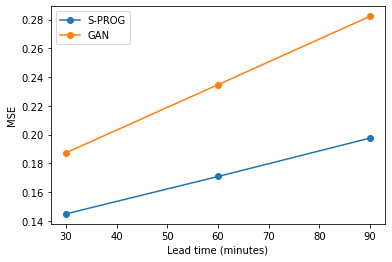

In [94]:
mse_sprog = [dic_lt['MSE'] for dic_lt in scores_sprog_cont]
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]

plt.plot([30,60,90], mse_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mse_gan, label = 'GAN', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE')
plt.legend()
plt.savefig('figures/results_MSE')

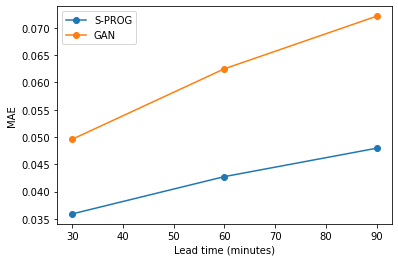

In [93]:
mae_sprog = [dic_lt['MAE'] for dic_lt in scores_sprog_cont]
mae_gan = [dic_lt['MAE'] for dic_lt in scores_gan_cont]


plt.plot([30,60,90], mae_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mae_gan, label = 'GAN', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MAE')
plt.legend()
plt.savefig('figures/results_MAE')

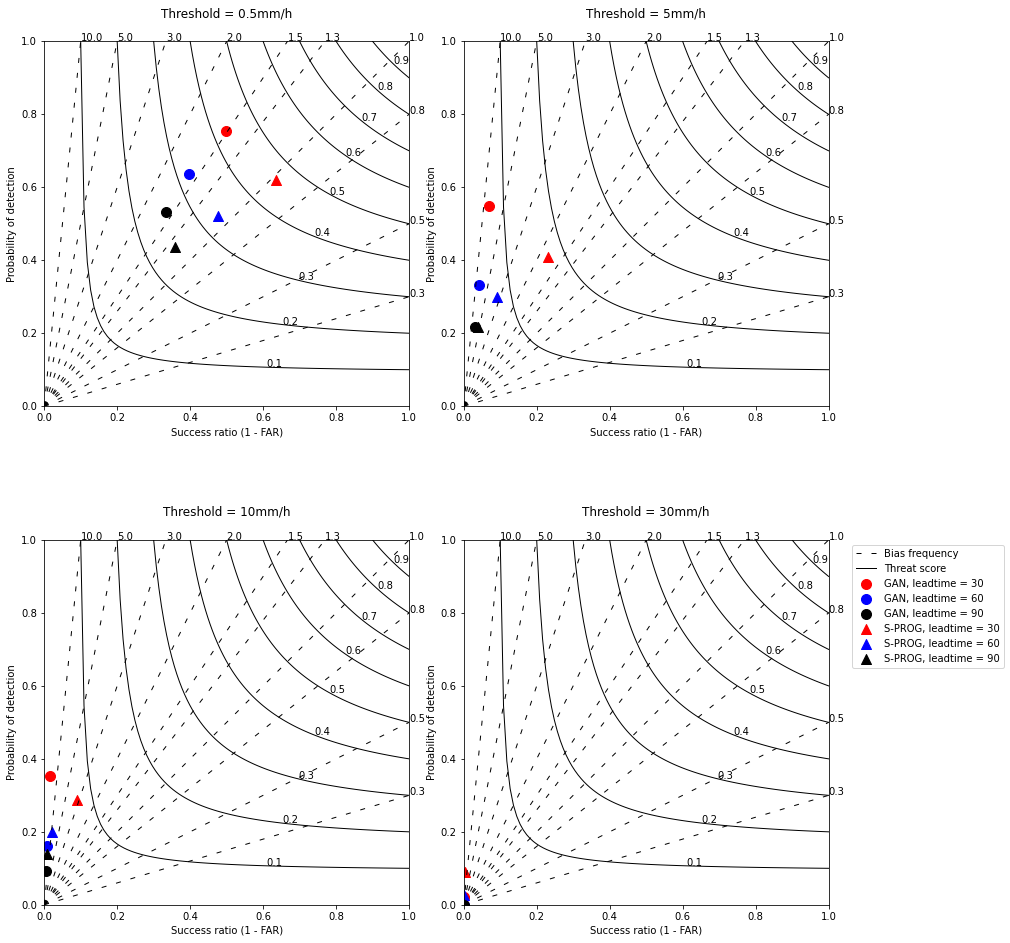

In [134]:
from plotter import performance_diagram

plt.figure(figsize=(14,14))
for i,thr in enumerate(evaluator.thresholds):
    plt.subplot(2,2,i+1)
    thr_gan = [score for score in scores_gan if score['threshold']  == thr ]
    thr_sprog = [score for score in scores_sprog if score['threshold']  == thr]

    scores = np.append(thr_gan, thr_sprog)
    scores.shape
    legend=False
    if thr == 30:
        legend=True
    performance_diagram(scores, legend)
    plt.title('Threshold = {}mm/h'.format(thr), y=1.05)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('figures/perf_diagrams_all')#, bbbox_layout='tight')

In [149]:
import pandas as pd

df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR        BIAS  leadtime
threshold                                                    
0.5        0.640509  0.336702  0.590320    1.569738        60
5.0        0.366356  0.043893  0.952791    7.685728        60
10.0       0.202077  0.008839  0.990854   21.093476        60
30.0       0.007130  0.000024  0.999976  264.725699        60

In [150]:
import pandas as pd

df = pd.DataFrame(scores_sprog)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR        BIAS  leadtime
threshold                                                    
0.5        0.525923  0.344855  0.509525    1.095072        60
5.0        0.308719  0.094378  0.879349    3.499023        60
10.0       0.208293  0.033168  0.960763   10.830000        60
30.0       0.038781  0.001037  0.998933  158.833315        60

In [166]:
# GAN trained on split by years vs GAN split on random split of train test
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_earthy_mountain_541_masked_val')
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_sage_blaze_543_val_randomsplit')
evaluator.load_accum_scores()
scores_ganr = evaluator.get_scores()[0]
scores_ganr_cont = evaluator.get_scores()[1]
for dic in scores_ganr:
    dic['nowcast_method'] = 'S-PROG'

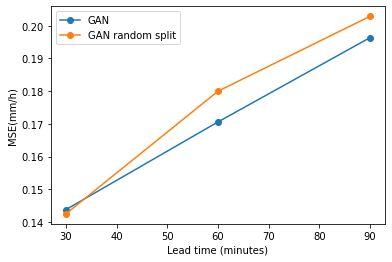

In [173]:
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]
mse_sprog = [dic_lt['MSE'] for dic_lt in scores_ganr_cont]

plt.plot([30,60,90], mse_gan, label='GAN', marker='o')
plt.plot([30,60,90], mse_sprog, label = 'GAN random split', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE(mm/h)')
plt.legend()
plt.savefig('figures/MSE_random_split')

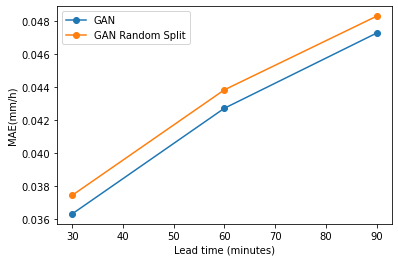

In [172]:
mae_gan = [dic_lt['MAE'] for dic_lt in scores_gan_cont]
mae_sprog = [dic_lt['MAE'] for dic_lt in scores_ganr_cont]

plt.plot([30,60,90], mae_gan, label='GAN', marker='o')
plt.plot([30,60,90], mae_sprog, label = 'GAN Random Split', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MAE(mm/h)')
plt.legend()
plt.savefig('figures/MAE_random_split')

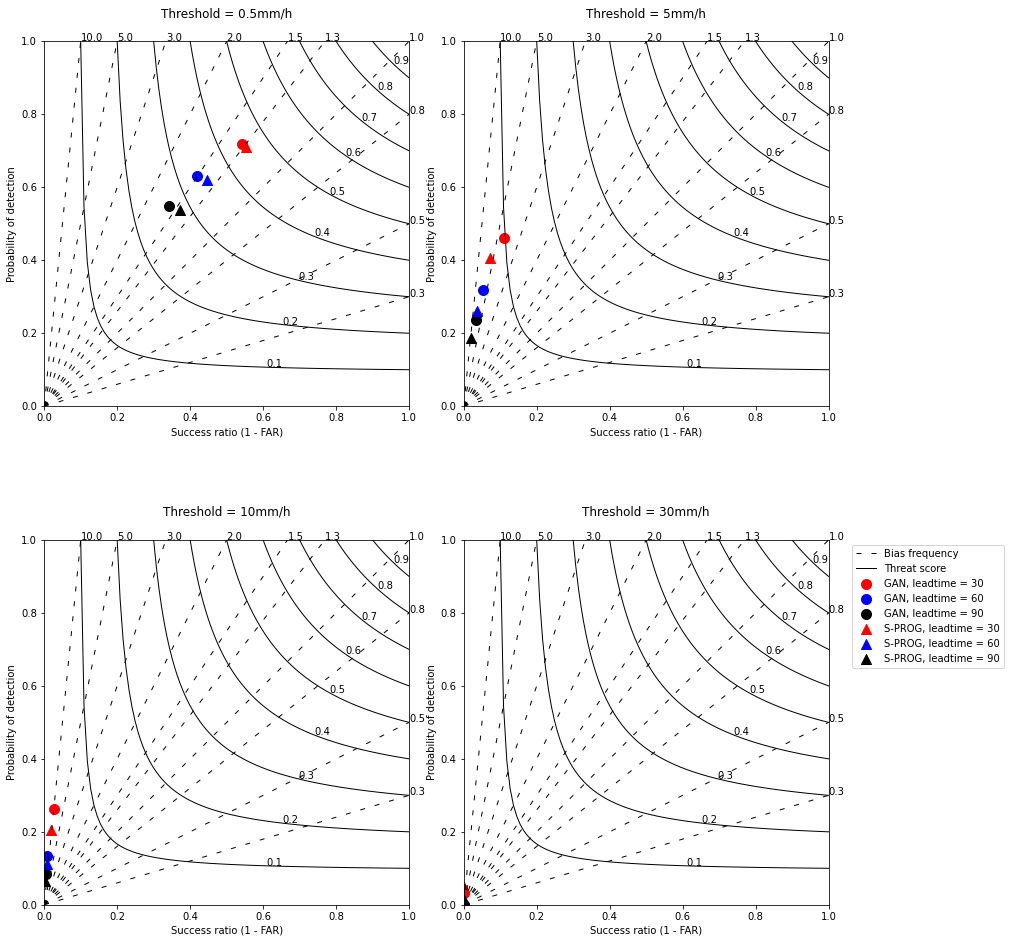

In [168]:
plt.figure(figsize=(14,14))
for i,thr in enumerate(evaluator.thresholds):
    plt.subplot(2,2,i+1)
    thr_gan = [score for score in scores_gan if score['threshold']  == thr ]
    thr_sprog = [score for score in scores_ganr if score['threshold']  == thr]

    scores = np.append(thr_gan, thr_sprog)
    scores.shape
    legend=False
    if thr == 30:
        legend=True
    performance_diagram(scores, legend)
    plt.title('Threshold = {}mm/h'.format(thr), y=1.05)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

In [5]:
np.load('results/n_sample_model_sunny_wind_549_val.npy')

array(6570.)

In [40]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_val_masked', thresholds=[.5,5,10,30])
evaluator.load_accum_scores()
scores_sprog = evaluator.get_scores()[0]
scores_sprog_cont = evaluator.get_scores()[1]
for dic in scores_sprog:
    dic['nowcast_method'] = 'S-PROG'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_silver_field_559_val', thresholds=[.5,5,10,30])
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_quiet_yogurt_535_val', thresholds=[.5,5,10,30])
evaluator.load_accum_scores()
scores_nag = evaluator.get_scores()[0]
scores_nag_cont = evaluator.get_scores()[1]
for dic in scores_nag:
    dic['nowcast_method'] = 'NAG'
    


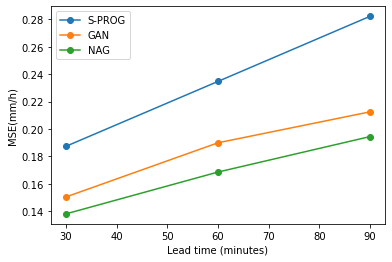

In [23]:
mse_sprog = [dic_lt['MSE'] for dic_lt in scores_sprog_cont]
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]
mse_nag = [dic_lt['MSE'] for dic_lt in scores_nag_cont]


plt.plot([30,60,90], mse_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mse_gan, label = 'GAN', marker = 'o')
plt.plot([30,60,90], mse_nag, label = 'NAG', marker = 'o')
#plt.plot([30,60], mse_anvil[:-1], label = 'ANVIL', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE(mm/h)')
plt.legend()
#
plt.savefig('figures/results_MSE')

In [25]:
import pandas as pd

df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR      BIAS  leadtime
threshold                                                  
0.5        0.632800  0.490937  0.319415  0.931284        60
5.0        0.569935  0.342670  0.544521  1.266885        60
10.0       0.257864  0.069093  0.914894  3.346903        60
30.0       0.093988  0.016262  0.980881  4.949346        60

In [41]:
import pandas as pd

df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR      BIAS  leadtime
threshold                                                  
0.5        0.632800  0.490937  0.319415  0.931284        60
5.0        0.569935  0.342670  0.544521  1.266885        60
10.0       0.257864  0.069093  0.914894  3.346903        60
30.0       0.093988  0.016262  0.980881  4.949346        60

In [26]:
import pandas as pd

df = pd.DataFrame(scores_sprog)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR        BIAS  leadtime
threshold                                                    
0.5        0.529486  0.346157  0.509525    1.103798        60
5.0        0.309376  0.094403  0.879349    3.513255        60
10.0       0.208497  0.033169  0.960763   10.857457        60
30.0       0.038781  0.001037  0.998933  158.833315        60

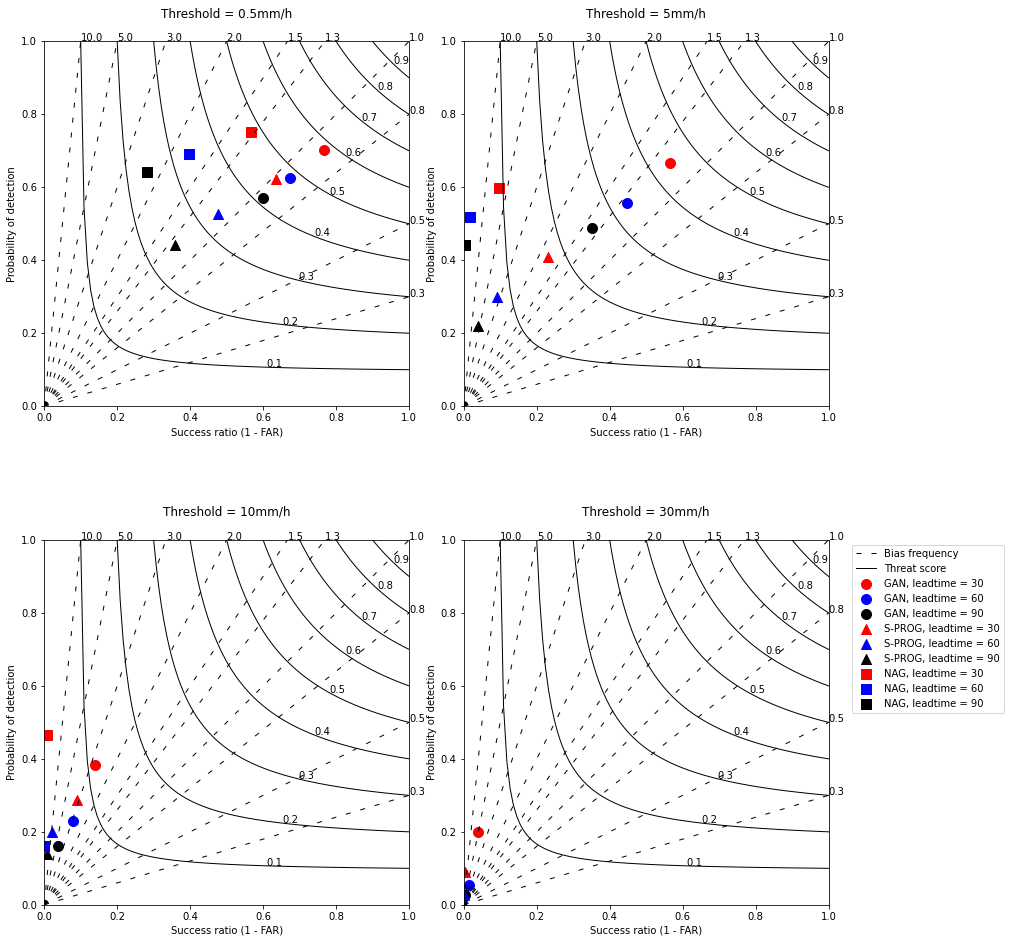

In [27]:
from plotter import performance_diagram

plt.figure(figsize=(14,14))
for i,thr in enumerate(evaluator.thresholds):
    plt.subplot(2,2,i+1)
    thr_gan = [score for score in scores_gan if score['threshold']  == thr ]
    thr_sprog = [score for score in scores_sprog if score['threshold']  == thr]
    thr_nag = [score for score in scores_nag if score['threshold']  == thr]
    #thr_anvil = [score for score in scores_anvil if score['threshold']  == thr]
    
    scores = np.concatenate((thr_gan, thr_sprog, thr_nag))
    legend=False
    if thr == 30:
        legend=True
    performance_diagram(scores, legend)
    plt.title('Threshold = {}mm/h'.format(thr), y=1.05)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig('figures/perf_diagrams_all')#, bbbox_layout='tight')

In [ ]:
def validate_model(model, run_name, on_test_set = False, random_split=False):
    if not on_test_set:
        dataset = 'datasets/val2019_3y_30m.npy'
        data_name = 'val'
        if random_split:
            dataset = 'datasets/val_randomsplit.npy'
            data_name+='_randomsplit'
    else:
        dataset = 'datasets/test2020_3y_30m.npy'
        data_name = 'test'
        if random_split:
            dataset = 'datasets/test_randomsplit.npy'
            data_name+='_randomsplit'
 
    
    # First load the data 
    list_IDs = np.load(dataset, allow_pickle = True)
    
    norm_method = 'minmax'
    downscale256 = True
    convert_to_dbz = True
    y_is_rtcor = True
    
    # Create generators:
    # Create generator to load preprocessed input data
    gen = DataGenerator(list_IDs, batch_size=1, x_seq_size=6, 
                                           y_seq_size=3, norm_method = norm_method, load_prep=True,
                             downscale256 = downscale256, convert_to_dbz = convert_to_dbz, 
                                  y_is_rtcor = y_is_rtcor, shuffle=False)
    # Create a generator that loads the original target data
    cp_gen = DataGenerator(gen.list_IDs, batch_size=gen.batch_size, x_seq_size=gen.inp_shape[0], 
                                           y_seq_size=gen.out_shape[0], norm_method=None, load_prep=False,
                             downscale256 = False, convert_to_dbz = False, 
                                  y_is_rtcor = gen.y_is_rtcor, shuffle=False, crop_y=False)

    # Init evaluator object to store metrics
    save_as = run_name + '_' + data_name
    evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = save_as)
    
    # Create directory to save predictions
    pred_path = config.dir_pred + save_as + '/' 
    if not os.path.exists(pred_path):
        os.makedirs(pred_path) 
    
    
    mask = get_mask_rtcor()
    
    # zip the two generators so that the preprocessed X matches the target Y data
    for (xs_prep, _), (_, ys), (_, ys_timestamps) in tqdm(zip(gen, cp_gen, list_IDs)):
        ys_pred = model.predict(xs_prep)        
        ys_pred = undo_prep(ys_pred, norm_method = norm_method, r_to_dbz=convert_to_dbz, 
                            downscale256 = downscale256)
        for y_pred, y_target in zip(ys_pred, ys):
            leadtimes = [30, 60, 90]
            for i, leadtime in enumerate(leadtimes):
                R_forecast = np.squeeze(np.array(y_pred[i])) * mask
                R_target = np.squeeze(np.array(y_target[i]))
                
                # save forecast:
                fn_forecast = ys_timestamps[i]+'_lt{}'.format(leadtime)
                np.save(pred_path+fn_forecast, R_forecast)
                
                # eval
                evaluator.verify(R_target, R_forecast, leadtime=leadtime)

In [3]:
dataset = 'datasets/val2019_3y_30m.npy'
# First load the data 
list_IDs = np.load(dataset, allow_pickle = True)

In [4]:
dataset = 'datasets/test2020_3y_30m.npy'
# First load the data 
list_IDs = np.load(dataset, allow_pickle = True)

In [5]:
target_gen = DataGenerator(list_IDs, batch_size=1, x_seq_size=6, 
                        y_seq_size=3, norm_method=None, load_prep=False,
                        downscale256 = False, convert_to_dbz = False, 
                        y_is_rtcor = True, shuffle=False, crop_y=False)

In [6]:
nowcast_method = 'GAN_val2' 
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = nowcast_method, thresholds = [0, 0.5, 1,2, 5, 10, 30])

TypeError: fss_init() missing 2 required positional arguments: 'thr' and 'scale'

In [6]:
import config

runname = 'model_silver_field_559_val/'
for (_, ys_target), (_, ys_timestamps) in tqdm(zip(target_gen, list_IDs)):
    leadtimes = [30, 60, 90]
    for i, leadtime in enumerate(leadtimes):
        fn_forecast = ys_timestamps[i]+'_lt{}'.format(leadtime)
        R_forecast = np.load(config.dir_pred + runname + fn_forecast + '.npy')
        R_target = np.squeeze(ys_target[0][i])
        
        evaluator.verify(R_target, R_forecast, leadtime=leadtime)

6570it [30:04,  3.64it/s]


In [26]:
import pandas as pd

evaluator_lstm = Evaluator(save_after_n_samples = 1, nowcast_method = 'GAN_val2')
evaluator_lstm.load_accum_scores()

scores_gan = evaluator_lstm.get_scores()[0]
scores_gan_cont = evaluator_lstm.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN LSTM'
    
df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR       BIAS  leadtime
threshold                                                   
0.0        0.632800  0.490937  0.319415   0.931284        60
0.5        0.569935  0.342670  0.544521   1.266885        60
5.0        0.257864  0.069093  0.914894   3.346903        60
10.0       0.093988  0.016262  0.980881   4.949346        60
30.0       0.006285  0.000352  0.999626  13.452679        60

In [27]:
import pandas as pd

evaluator_lstm = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_silver_field_559_val')
evaluator_lstm.load_accum_scores()

scores_AENN = evaluator_lstm.get_scores()[0]
scores_AENN_cont = evaluator_lstm.get_scores()[1]
for dic in scores_AENN:
    dic['nowcast_method'] = 'GAN'
    
df = pd.DataFrame(scores_AENN)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR       BIAS  leadtime
threshold                                                   
0.0        0.632800  0.490937  0.319415   0.931284        60
0.5        0.569935  0.342670  0.544521   1.266885        60
5.0        0.257864  0.069093  0.914894   3.346903        60
10.0       0.093988  0.016262  0.980881   4.949346        60
30.0       0.006285  0.000352  0.999626  13.452679        60

In [28]:
scores_AENN_cont

[{'MSE': array(0.15029913), 'MAE': array(0.03840398), 'leadtime': 30},
 {'MSE': array(0.18990595), 'MAE': array(0.04665546), 'leadtime': 60},
 {'MSE': array(0.21253166), 'MAE': array(0.0505251), 'leadtime': 90}]

In [22]:
import pandas as pd

evaluator_gru = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_easy_vortex_560_val')
evaluator_gru.load_accum_scores()

scores_gan = evaluator_gru.get_scores()[0]
scores_gan_cont = evaluator_gru.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN GRU'
    
df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()


POD       CSI       FAR        BIAS  leadtime
threshold                                                    
0.0        0.526157  0.460772  0.219938    0.671388        60
0.5        0.616078  0.352549  0.553946    1.404243        60
5.0        0.333168  0.047373  0.947816    8.570834        60
10.0       0.145996  0.009517  0.989913   25.195584        60
30.0       0.014418  0.000349  0.999642  128.180726        60

In [19]:
scores_gan_cont

[{'MSE': array(0.14335776), 'MAE': array(0.03742961), 'leadtime': 30},
 {'MSE': array(0.1702961), 'MAE': array(0.04491886), 'leadtime': 60},
 {'MSE': array(0.19528845), 'MAE': array(0.05015019), 'leadtime': 90}]

In [14]:
import pandas as pd

evaluator_gru = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_val2')
evaluator_gru.load_accum_scores()

scores_gan = evaluator_gru.get_scores()[0]
scores_gan_cont = evaluator_gru.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN GRU'
    
df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()


FileNotFoundError: [Errno 2] No such file or directory: 'results/cat_dicts_SPROG_val2.npy'

In [37]:
import pandas as pd

evaluator_lstm = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_easy_vortex_560_val')
evaluator_lstm.load_accum_scores()

scores_AENN = evaluator_lstm.get_scores()[0]
scores_AENN_cont = evaluator_lstm.get_scores()[1]
for dic in scores_AENN:
    dic['nowcast_method'] = 'GAN'
df = pd.DataFrame(scores_AENN)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR        BIAS  leadtime
threshold                                                    
0.0        0.526157  0.460772  0.219938    0.671388        60
0.5        0.616078  0.352549  0.553946    1.404243        60
5.0        0.333168  0.047373  0.947816    8.570834        60
10.0       0.145996  0.009517  0.989913   25.195584        60
30.0       0.014418  0.000349  0.999642  128.180726        60

In [46]:
import pandas as pd

evaluator_gru = Evaluator(save_after_n_samples = 1, nowcast_method =  'model_silver_field_559_val')
evaluator_gru.load_accum_scores()

scores_gan_gru = evaluator_gru.get_scores()[0]
scores_gan_gru_cont = evaluator_gru.get_scores()[1]
for dic in scores_gan_gru:
    dic['nowcast_method'] = 'GAN GRU'
    
df = pd.DataFrame(scores_gan_gru)
df_g = df.groupby('threshold')

df_g.mean()


POD       CSI       FAR       BIAS  leadtime
threshold                                                   
0.0        0.632800  0.490937  0.319415   0.931284        60
0.5        0.569935  0.342670  0.544521   1.266885        60
5.0        0.257864  0.069093  0.914894   3.346903        60
10.0       0.093988  0.016262  0.980881   4.949346        60
30.0       0.006285  0.000352  0.999626  13.452679        60

In [47]:
import pandas as pd

evaluator_gru = Evaluator(save_after_n_samples = 1, nowcast_method =  'model_silver_field_559_test')
evaluator_gru.load_accum_scores()

scores_gan_gru = evaluator_gru.get_scores()[0]
scores_gan_gru_cont = evaluator_gru.get_scores()[1]
for dic in scores_gan_gru:
    dic['nowcast_method'] = 'GAN GRU'
    
df = pd.DataFrame(scores_gan_gru)
df_g = df.groupby('threshold')

df_g.mean()


POD       CSI       FAR       BIAS  leadtime
threshold                                                   
0.0        0.638781  0.494176  0.320035   0.940864        60
0.5        0.579209  0.354439  0.529002   1.244655        60
5.0        0.197535  0.053911  0.932118   3.285067        60
10.0       0.062562  0.010948  0.986979   4.359348        60
30.0       0.006183  0.000266  0.999721  12.791823        60

In [34]:
scores_AENN_cont

[{'MSE': array(0.14335776), 'MAE': array(0.03742961), 'leadtime': 30},
 {'MSE': array(0.1702961), 'MAE': array(0.04491886), 'leadtime': 60},
 {'MSE': array(0.19528845), 'MAE': array(0.05015019), 'leadtime': 90}]

In [35]:
scores_gan_gru_cont

[{'MSE': array(0.15029913), 'MAE': array(0.03840398), 'leadtime': 30},
 {'MSE': array(0.18990595), 'MAE': array(0.04665546), 'leadtime': 60},
 {'MSE': array(0.21253166), 'MAE': array(0.0505251), 'leadtime': 90}]

In [5]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_test', thresholds = [0, 0.5, 5, 10, 30])
evaluator.load_accum_scores()
scores_sprog = evaluator.get_scores()[0]
scores_sprog_cont = evaluator.get_scores()[1]
for dic in scores_sprog:
    dic['nowcast_method'] = 'S-PROG'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'GAN_test2', thresholds = [0, 0.5, 1,2, 5, 10, 30])
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_quiet_yogurt_535_test', thresholds = [0, 0.5, 5, 10, 30])
evaluator.load_accum_scores()
scores_nag = evaluator.get_scores()[0]
scores_nag_cont = evaluator.get_scores()[1]
for dic in scores_nag:
    dic['nowcast_method'] = 'NAG'

In [31]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_silver_field_559_test', thresholds=[.5,5,10,30])
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_sage_blaze_543_val_randomsplit', thresholds=[.5,5,10,30])
evaluator.load_accum_scores()
scores_gan_r = evaluator.get_scores()[0]
scores_gan_r_cont = evaluator.get_scores()[1]
for dic in scores_gan_r:
    dic['nowcast_method'] = 'GAN Random Split'

In [46]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'GAN_test2', 
                      thresholds = [0, 0.5, 1,2, 5, 10, 30])
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_silver_field_559_test_nearest', 
                      thresholds = [0, 0.5, 1,2, 5, 10, 30])
evaluator.load_accum_scores()
scores_gan2 = evaluator.get_scores()[0]
scores_gan_cont2 = evaluator.get_scores()[1]
for dic in scores_gan2:
    dic['nowcast_method'] = 'GAN'

In [47]:
import pandas as pd

# bilinear upscaling
df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR       BIAS  leadtime
threshold                                                   
0.0        0.638781  0.494176  0.320035   0.940864        60
0.5        0.579209  0.354439  0.529002   1.244655        60
1.0        0.516837  0.282645  0.621572   1.393156        60
2.0        0.409056  0.182412  0.756411   1.745550        60
5.0        0.197535  0.053911  0.932118   3.285067        60
10.0       0.062562  0.010948  0.986979   4.359348        60
30.0       0.006183  0.000266  0.999721  12.791823        60

In [43]:
import pandas as pd

# nearest neightbour upscaling
df = pd.DataFrame(scores_gan2)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR      BIAS  leadtime
threshold                                                  
0.0        0.684937  0.491136  0.370631  1.090172        60
0.5        0.569653  0.345821  0.537650  1.246899        60
1.0        0.502820  0.272402  0.632431  1.393900        60
2.0        0.386793  0.173135  0.764910  1.707769        60
5.0        0.182789  0.054793  0.928290  2.887322        60
10.0       0.056583  0.012851  0.983820  3.596009        60
30.0       0.005301  0.000456  0.999492  4.710913        60

In [29]:
import pandas as pd

df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR      BIAS  leadtime
threshold                                                  
0.0        0.657985  0.510186  0.311602  0.956739        60
0.5        0.592006  0.384541  0.483492  1.159547        60
1.0        0.532347  0.327470  0.546697  1.195558        60
2.0        0.423770  0.231336  0.667514  1.313129        60
5.0        0.183704  0.066746  0.906686  2.316017        60
10.0       0.046664  0.012446  0.983617  2.599143        60
30.0       0.009772  0.000909  0.999001  6.369328        60

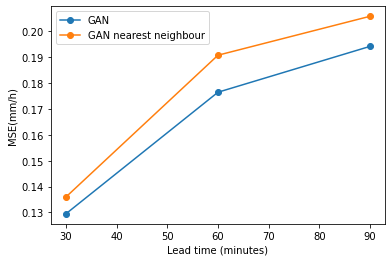

In [48]:
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]
mse_gan2 = [dic_lt['MSE'] for dic_lt in scores_gan_cont2]

plt.plot([30,60,90], mse_gan, label = 'GAN', marker = 'o')
plt.plot([30,60,90], mse_gan2, label = 'GAN nearest neighbour', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE(mm/h)')
plt.legend()

#plt.savefig('figures/results_MSE')

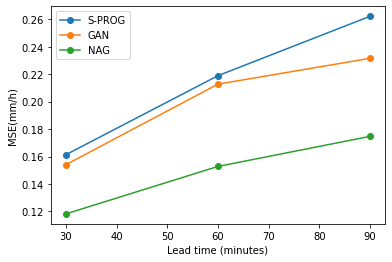

In [21]:
mse_sprog = [dic_lt['MSE'] for dic_lt in scores_sprog_cont]
mse_nag = [dic_lt['MSE'] for dic_lt in scores_nag_cont]
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]


plt.plot([30,60,90], mse_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mse_gan2, label = 'GAN', marker = 'o')
plt.plot([30,60,90], mse_nag, label = 'NAG', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE(mm/h)')
plt.legend()

#plt.savefig('figures/results_MSE')

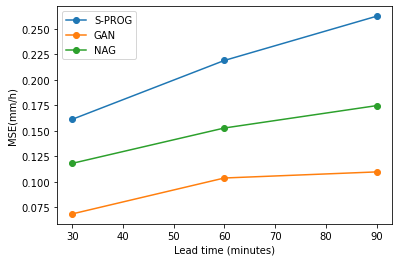

In [6]:
mse_sprog = [dic_lt['MSE'] for dic_lt in scores_sprog_cont]
mse_nag = [dic_lt['MSE'] for dic_lt in scores_nag_cont]
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]


plt.plot([30,60,90], mse_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mse_gan, label = 'GAN', marker = 'o')
plt.plot([30,60,90], mse_nag, label = 'NAG', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE(mm/h)')
plt.legend()

#plt.savefig('figures/results_MSE')

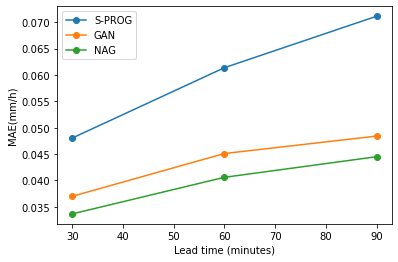

In [67]:
mse_sprog = [dic_lt['MAE'] for dic_lt in scores_sprog_cont]
mse_nag = [dic_lt['MAE'] for dic_lt in scores_nag_cont]
mse_gan = [dic_lt['MAE'] for dic_lt in scores_gan_cont]


plt.plot([30,60,90], mse_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mse_gan, label = 'GAN', marker = 'o')
plt.plot([30,60,90], mse_nag, label = 'NAG', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MAE(mm/h)')
plt.legend()

plt.savefig('figures/results_MAE')

In [54]:
import pandas as pd

df = pd.DataFrame(scores_sprog)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR       BIAS  leadtime
threshold                                                   
0.0        0.685123  0.486603  0.379711   1.103443        60
0.5        0.532023  0.349988  0.504488   1.096363        60
5.0        0.252757  0.073095  0.906457   4.030695        60
10.0       0.154325  0.021512  0.974968  14.563783        60
30.0       0.173516  0.002720  0.997170        inf        60

In [60]:
import pandas as pd

df = pd.DataFrame(scores_nag)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR        BIAS  leadtime
threshold                                                    
0.0        0.304658  0.302325  0.025308    0.312348        60
0.5        0.708155  0.362886  0.574960    1.767513        60
5.0        0.448884  0.021994  0.976961  339.153432        60
10.0       0.623001  0.001244  0.998748         inf        60
30.0            NaN  0.000000  1.000000         inf        60

In [7]:
import pandas as pd

df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR      BIAS  leadtime
threshold                                                  
0.0        0.657985  0.510186  0.311602  0.956739        60
0.5        0.592006  0.384541  0.483492  1.159547        60
1.0        0.532347  0.327470  0.546697  1.195558        60
2.0        0.423770  0.231336  0.667514  1.313129        60
5.0        0.183704  0.066746  0.906686  2.316017        60
10.0       0.046664  0.012446  0.983617  2.599143        60
30.0       0.009772  0.000909  0.999001  6.369328        60

ValueError: num must be 1 <= num <= 6, not 7

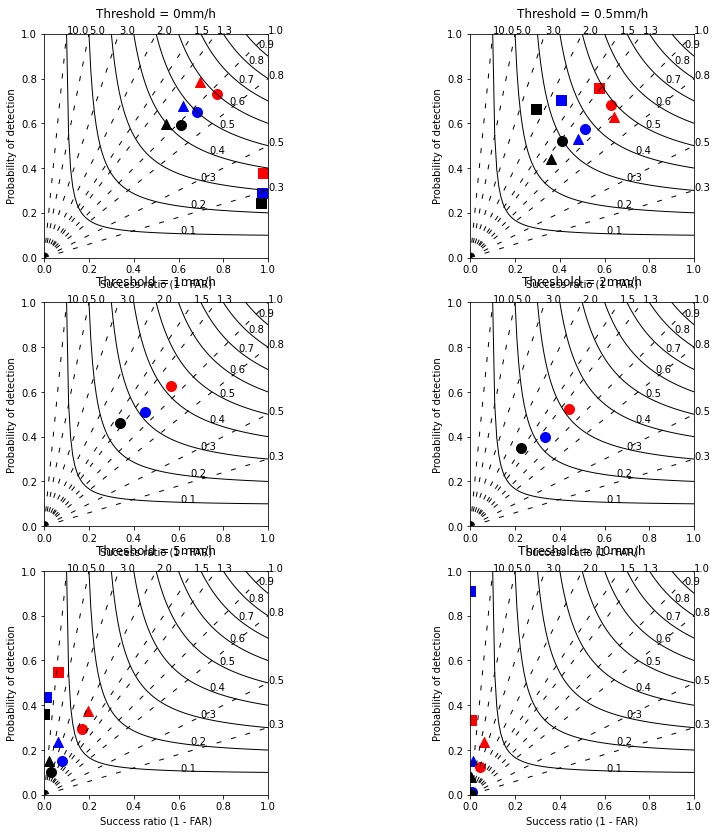

In [26]:
from plotter import performance_diagram

plt.figure(figsize=(14,14))
for i,thr in enumerate(evaluator.thresholds):
    plt.subplot(3,2,i+1)
    thr_sprog = [score for score in scores_sprog if score['threshold']  == thr]
    thr_gan = [score for score in scores_gan if score['threshold']  == thr ]
    thr_nag = [score for score in scores_nag if score['threshold']  == thr]
    #thr_anvil = [score for score in scores_anvil if score['threshold']  == thr]
    
    scores = np.concatenate((thr_sprog, thr_gan, thr_nag))
    legend=False
    if thr == 30:
        legend=True
    performance_diagram(scores, legend)
    plt.title('Threshold = {}mm/h'.format(thr), y=1.05)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
#plt.savefig('figures/perf_diagrams_all')#, bbbox_layout='tight')

In [74]:
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_silver_field_559_test')
evaluator.load_accum_scores()
scores_gan = evaluator.get_scores()[0]
scores_gan_cont = evaluator.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_sage_blaze_543_val_randomsplit', thresholds=[.5,5,10,30])
evaluator.load_accum_scores()
scores_gan_r = evaluator.get_scores()[0]
scores_gan_r_cont = evaluator.get_scores()[1]
for dic in scores_gan_r:
    dic['nowcast_method'] = 'GAN Random Split'

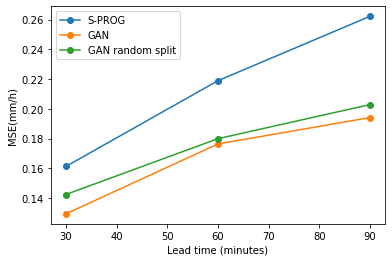

In [84]:
mse_gan = [dic_lt['MSE'] for dic_lt in scores_gan_cont]
mse_gan_r = [dic_lt['MSE'] for dic_lt in scores_gan_r_cont]
plt.plot([30,60,90], mse_sprog, label='S-PROG', marker='o')
plt.plot([30,60,90], mse_gan, label='GAN', marker='o')
plt.plot([30,60,90], mse_gan_r, label = 'GAN random split', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MSE(mm/h)')
plt.legend()
#plt.savefig('figures/MSE_random_split')

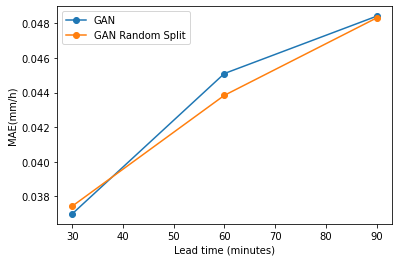

In [77]:
mae_gan = [dic_lt['MAE'] for dic_lt in scores_gan_cont]
mae_gan_r = [dic_lt['MAE'] for dic_lt in scores_gan_r_cont]

plt.plot([30,60,90], mae_gan, label='GAN', marker='o')
plt.plot([30,60,90], mae_gan_r, label = 'GAN Random Split', marker = 'o')
plt.xlabel('Lead time (minutes)')
plt.ylabel('MAE(mm/h)')
plt.legend()
plt.savefig('figures/MAE_random_split')

In [78]:
import pandas as pd

df = pd.DataFrame(scores_gan)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR       BIAS  leadtime
threshold                                                   
0.0        0.638781  0.494176  0.320035   0.940864        60
0.5        0.579209  0.354439  0.529002   1.244655        60
5.0        0.197535  0.053911  0.932118   3.285067        60
10.0       0.062562  0.010948  0.986979   4.359348        60
30.0       0.006183  0.000266  0.999721  12.791823        60

In [79]:
import pandas as pd

df = pd.DataFrame(scores_gan_r)
df_g = df.groupby('threshold')
df_g.mean()

POD       CSI       FAR        BIAS  leadtime
threshold                                                    
0.5        0.622559  0.361139  0.542951    1.373444        60
5.0        0.285351  0.038979  0.957060    7.279672        60
10.0       0.128039  0.008623  0.990845   16.801294        60
30.0       0.024784  0.000308  0.999688  112.733621        60

In [51]:
evaluator.cat_dicts.shape

(3, 7)

In [52]:
evaluator.cont_dicts.shape

(3,)

In [72]:
fss_dicts = np.array([[[fss_init(thr = thr, scale = scales) for scale in scales] for thr in thresholds] for _ in leadtimes])

In [73]:
fss_dicts.shape

(3, 7, 6)

In [ ]:
def verify(self, y, y_pred, leadtime):
        index = self.leadtimes.index(leadtime)
        for cat_dict in self.cat_dicts[index]:
            det_cat_fct_accum(cat_dict, obs = y, pred = y_pred)
        det_cont_fct_accum(self.cont_dicts[index], obs = y, pred = y_pred)
        
        for i, fss_thr in enumerate(self.fss_dicts[index]):
            for j, fss_scale in enumerate(fss_thr):
                fss_accum(self.fss_dicts[index, i, j], X_o = y, X_f = y_pred)
                
        # Make checkpount if model went through n samples
        self.n_verifies +=1
        # verify is called for each lead time
        n_samples = self.n_verifies/len(self.leadtimes)
        if  self.save_after_n_samples > 0 and n_samples % self.save_after_n_samples == 0:
            self.save_accum_scores(n_samples)

In [84]:
from model_builder import GAN
from plotter import plot_target_pred

run_name = 'model_silver_field_559'
path_checkpoint = 'saved_models/' + run_name

rnn_type = 'GRU'
x_length = 6
y_length = 3
resize_method = tf.image.ResizeMethod.BILINEAR
#resize_method = tf.image.ResizeMethod.NEAREST_NEIGHBOR


model = GAN(rnn_type=rnn_type, x_length=x_length, 
            y_length=y_length, architecture='AENN', relu_alpha=.2,
           l_adv = 0.003, l_rec = 1, g_cycles=3, label_smoothing=0.2
            , norm_method = 'minmax', downscale256 = True, rec_with_mae= False,
           r_to_dbz = True, batch_norm = False)
model.load_weights(path_checkpoint)


In [105]:
def fss_accum(fss, X_f, X_o):
    """Accumulate forecast-observation pairs to an FSS object.
    Parameters
    -----------
    fss: dict
        The FSS object initialized with
        :py:func:`pysteps.verification.spatialscores.fss_init`.
    X_f: array_like
        Array of shape (m, n) containing the forecast field.
    X_o: array_like
        Array of shape (m, n) containing the observation field.
    """
    if len(X_f.shape) != 2 or len(X_o.shape) != 2 or X_f.shape != X_o.shape:
        message = "X_f and X_o must be two-dimensional arrays"
        message += " having the same shape"
        raise ValueError(message)

    X_f = X_f.copy()
    X_f[~np.isfinite(X_f)] = fss["thr"] - 1
    X_o = X_o.copy()
    X_o[~np.isfinite(X_o)] = fss["thr"] - 1

    # Convert to binary fields with the given intensity threshold
    I_f = (X_f >= fss["thr"]).astype(float)
    I_o = (X_o >= fss["thr"]).astype(float)

    # Compute fractions of pixels above the threshold within a square
    # neighboring area by applying a 2D moving average to the binary fields
    if fss["scale"] > 1:
        S_f = uniform_filter(I_f, size=fss["scale"], mode="constant", cval=0.0)
        S_o = uniform_filter(I_o, size=fss["scale"], mode="constant", cval=0.0)
    else:
        S_f = I_f
        S_o = I_o

    fss["sum_obs_sq"] += np.nansum(S_o ** 2)
    fss["sum_fct_obs"] += np.nansum(S_f * S_o)
    fss["sum_fct_sq"] += np.nansum(S_f ** 2)

In [112]:
fss

{'thr': 0,
 'scale': 1,
 'sum_fct_sq': 1071000.0,
 'sum_fct_obs': 1071000.0,
 'sum_obs_sq': 1071000.0}

In [111]:
fss = fss_dicts[0,0,0]
fss_accum(fss, X_f = R_forecast, X_o = R_target)

In [116]:
y_pred.shape

TensorShape([3, 765, 700, 1])

In [121]:
y_pred[0,:,:,0].shape

TensorShape([765, 700])

In [131]:
a = np.array(y_pred[0])

In [129]:
np.squeeze(a)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [135]:
R_forecast = np.squeeze(np.array(y_pred[3]))

InvalidArgumentError: slice index 3 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

0it [00:00, ?it/s]

[list(['201912301135', '201912301140', '201912301145', '201912301150', '201912301155', '201912301200'])
 list(['201912301230', '201912301300', '201912301330'])]
6570
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)


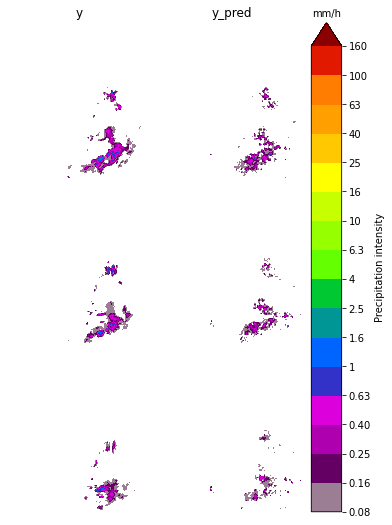

1it [00:01,  1.76s/it]

1
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)


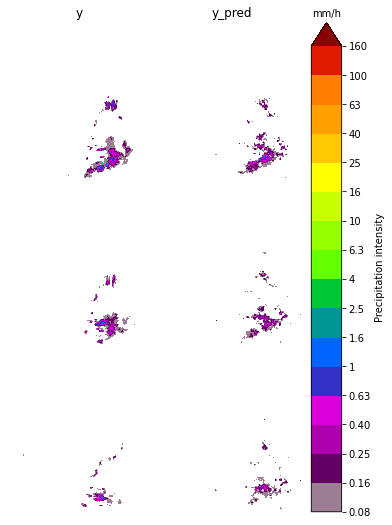

2it [00:03,  1.81s/it]

2
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)


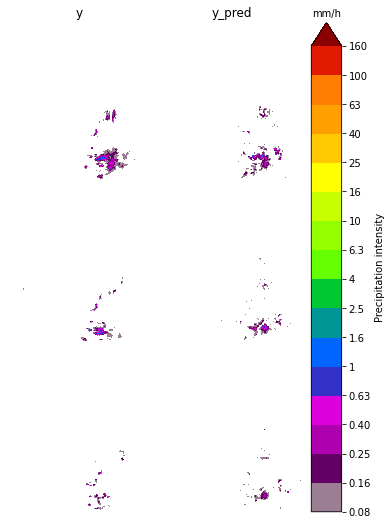

3it [00:05,  1.79s/it]

3
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)


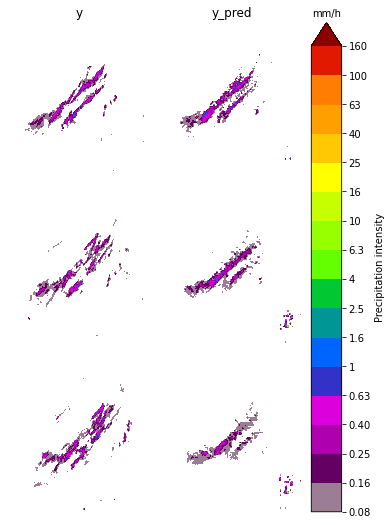

4it [00:07,  1.77s/it]

4
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)


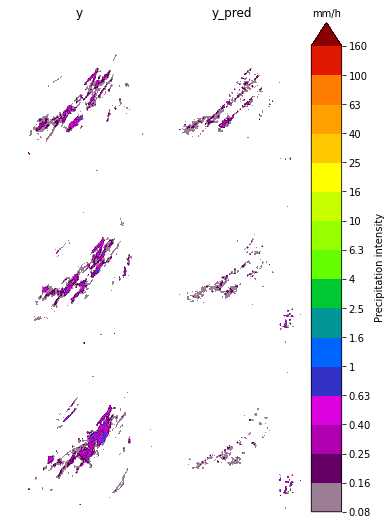

5it [00:08,  1.81s/it]

5
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)
(3, 765, 700, 1) (3, 765, 700, 1)


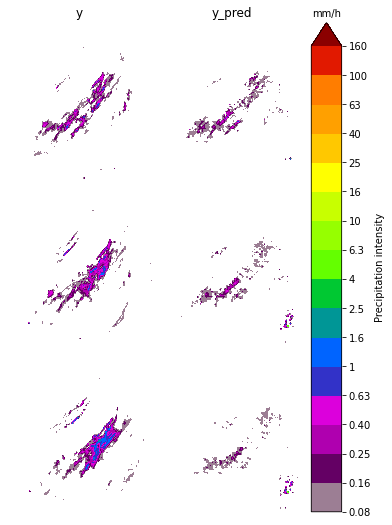

5it [00:10,  2.15s/it]

6


In [136]:
from pysteps.verification.spatialscores import fss_init, fss_accum, fss_compute

thresholds = [0, 0.5, 1, 2, 5, 10, 30]
scales = [1, 2, 4, 16, 32, 64]
fss_dicts = np.array([[[fss_init(thr = thr, scale = scale) for scale in scales] for thr in thresholds] for _ in leadtimes])


c = 0
list_IDs = np.load('datasets/val2019_3y_30m.npy', allow_pickle = True)
print(list_IDs[-1])
print(len(list_IDs))

gen = DataGenerator(list_IDs, batch_size=1, x_seq_size=6, 
                                       y_seq_size=3, norm_method='minmax', load_prep=True,
                         downscale256 = True, convert_to_dbz = True, 
                              y_is_rtcor = True, shuffle=False)


cp_gen = DataGenerator(gen.list_IDs, batch_size=gen.batch_size, x_seq_size=gen.inp_shape[0], 
                                       y_seq_size=gen.out_shape[0], norm_method=None, load_prep=False,
                         downscale256 = False, convert_to_dbz = False, 
                              y_is_rtcor = gen.y_is_rtcor, shuffle=False, crop_y=False)

for (xs_prep, ys_prep), (_, ys) in tqdm(zip(gen, cp_gen)):

    ys_pred = model.predict(xs_prep)        
    ys_pred = undo_prep(ys_pred)
    
    
    for y_pred, y_target in zip(ys_pred, ys):
        for index, leadtime in enumerate(leadtimes):
                print(y_pred.shape, y_target.shape)
                R_forecast = np.squeeze(np.array(y_pred[index])) # * mask
                R_target = np.squeeze(np.array(y_target[index]))
                
                
                # eval
                for i, fss_thr in enumerate(fss_dicts[index]):
                    for j, fss_scale in enumerate(fss_thr):
                        fss_accum(fss_dicts[index, i, j], X_o = R_target, X_f = R_forecast)
                
        leadtimes = [30, 60, 90]          
        plot_target_pred(y_target, y_pred)
        plt.show()
    c+=1
    print(c)
    if c>5:
        break

In [168]:
pysteps.verification.detcontscores.det_cont_fct

(765, 700)

In [178]:
R_target[:,0].shape

(765,)

In [177]:
mse = tf.keras.metrics.mean_squared_error(R_target, R_forecast)
mse.shape

TensorShape([765])

In [180]:
mse = tf.keras.metrics.mean_squared_error(R_target, R_forecast)
mse.shape

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [183]:
d = R_target- R_forecast
d.shape

(765, 700)

In [192]:
d = np.array([d])

In [195]:
mse = np.linalg.norm(d, axis=0)
mse.shape

(765, 700)

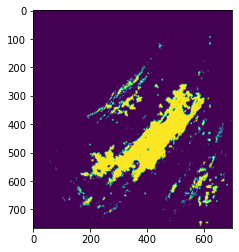

In [197]:
plt.imshow(mse>0)

In [170]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(R_target, R_forecast, multioutput='raw_values')
mse

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.88235299e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [156]:
b = fss_dicts[0,1,-1]
print(pysteps.verification.spatialscores.fss_compute(b))
b

0.5873448532059716


{'thr': 0.5,
 'scale': 64,
 'sum_fct_sq': 324.30589842796326,
 'sum_fct_obs': 342.178652882576,
 'sum_obs_sq': 840.8652987480164}

In [144]:
import pysteps



0.17973214948657346

In [ ]:
from pysteps.verification.spatialscores import fss_init, fss_accum, fss_compute

thresholds = [0, 0.5, 1, 2, 5, 10, 30]
scales = [1, 2, 4, 16, 32, 64]
fss_dicts = np.array([[[fss_init(thr = thr, scale = scale) for scale in scales] for thr in thresholds] for _ in leadtimes])


c = 0
list_IDs = np.load('datasets/val2019_3y_30m.npy', allow_pickle = True)
print(list_IDs[-1])
print(len(list_IDs))

gen = DataGenerator(list_IDs, batch_size=1, x_seq_size=6, 
                                       y_seq_size=3, norm_method='minmax', load_prep=True,
                         downscale256 = True, convert_to_dbz = True, 
                              y_is_rtcor = True, shuffle=False)


cp_gen = DataGenerator(gen.list_IDs, batch_size=gen.batch_size, x_seq_size=gen.inp_shape[0], 
                                       y_seq_size=gen.out_shape[0], norm_method=None, load_prep=False,
                         downscale256 = False, convert_to_dbz = False, 
                              y_is_rtcor = gen.y_is_rtcor, shuffle=False, crop_y=False)

Y_target = []
Y_pred = []
for (xs_prep, ys_prep), (_, ys) in tqdm(zip(gen, cp_gen)):

    ys_pred = model.predict(xs_prep)        
    ys_pred = undo_prep(ys_pred)
        
    Y_target.append(ys)
    Y_pred.append(ys_pred)
#     for y_pred, y_target in zip(ys_pred, ys):
#         for index, leadtime in enumerate(leadtimes):
#                 print(y_pred.shape, y_target.shape)
#                 R_forecast = np.squeeze(np.array(y_pred[index])) # * mask
#                 R_target = np.squeeze(np.array(y_target[index]))
                
                
#                 # eval
#                 for i, fss_thr in enumerate(fss_dicts[index]):
#                     for j, fss_scale in enumerate(fss_thr):
#                         fss_accum(fss_dicts[index, i, j], X_o = R_target, X_f = R_forecast)
                
#         leadtimes = [30, 60, 90]          
#         plot_target_pred(y_target, y_pred)
#         plt.show()
#     c+=1
#     print(c)
#     if c>5:
#         break

0it [00:00, ?it/s]

[list(['201912301135', '201912301140', '201912301145', '201912301150', '201912301155', '201912301200'])
 list(['201912301230', '201912301300', '201912301330'])]
6570


2832it [13:52,  2.74it/s]

In [114]:
evaluator_sprog = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_test_odd_fss')
evaluator_sprog.load_accum_scores()
scores_sprog = evaluator_sprog.get_scores()[0]
scores_sprog_cont = evaluator_sprog.get_scores()[1]
for dic in scores_sprog:
    dic['nowcast_method'] = 'S-PROG'
    
evaluator_gan = Evaluator(save_after_n_samples = 1, nowcast_method = 'GAN_test_odd_fss')
evaluator_gan.load_accum_scores()
scores_gan = evaluator_gan.get_scores()[0]
scores_gan_cont = evaluator_gan.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator_nag = Evaluator(save_after_n_samples = 1, nowcast_method = 'NAG_test_odd_fss')
evaluator_nag.load_accum_scores()
scores_nag = evaluator_nag.get_scores()[0]
scores_nag_cont = evaluator_nag.get_scores()[1]
for dic in scores_nag:
    dic['nowcast_method'] = 'NAG'

In [115]:
evaluator_sprog.fss_dicts.shape

(3, 7, 6)

In [120]:
a = evaluator_sprog.fss_dicts[1][2][1]
print(a)
from pysteps.verification.spatialscores import fss_compute
fss_compute(a)

{'thr': 1, 'scale': 3, 'sum_fct_sq': 25747093.827160455, 'sum_fct_obs': 13166725.259259226, 'sum_obs_sq': 30556080.4567901}


0.4677080973394586

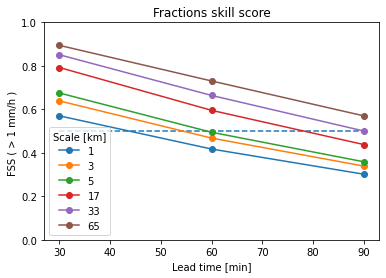

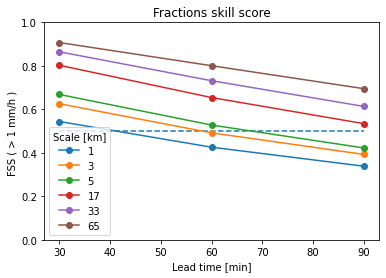

In [123]:
thr_i=2
score = []

thresholds = [0, 0.5, 1, 2, 5, 10, 30]
scales = [1, 3, 5, 17, 33, 65]

for i in range(3):
    score_ = []
    for scale in range(len(scales)):
        score_.append(fss_compute(evaluator_sprog.fss_dicts[i][thr_i][scale]))
    score.append(score_)

plt.figure()
x = np.arange(1, 3 + 1) * 30
plt.plot(x, score, marker='o')
plt.legend(scales, title="Scale [km]")
plt.xlabel("Lead time [min]")
plt.ylabel("FSS ( > {} mm/h ) ".format(thresholds[thr_i]))
plt.title("Fractions skill score")
plt.ylim(0,1)
plt.hlines(0.5, 30, 90, linestyle =  '--')
score = []

thresholds = [0, 0.5, 1, 2, 5, 10, 30]
scales = [1, 3, 5, 17, 33, 65]

for i in range(3):
    score_ = []
    for scale in range(len(scales)):
        score_.append(fss_compute(evaluator_gan.fss_dicts[i][thr_i][scale]))
    score.append(score_)

plt.figure()
x = np.arange(1, 3 + 1) * 30
plt.plot(x, score, marker='o')
plt.legend(scales, title="Scale [km]")
plt.xlabel("Lead time [min]")
plt.ylabel("FSS ( > {} mm/h ) ".format(thresholds[thr_i]))
plt.title("Fractions skill score")
plt.ylim(0,1)
plt.hlines(0.5, 30, 90, linestyle =  '--')

In [124]:
import pandas as pd
import seaborn as sns

In [125]:
lead_times = [30, 60, 90]
skillfull_lts = np.zeros((len(scales),len(thresholds)))
for scale_i, scale in enumerate(scales):
    # define fss useful:
    fss_u = 0.5 + ((scale*scale)/(765*700))/2
    
    
    for thr_i, thr in enumerate(thresholds):
        skill_lt = 0
        for lt_i, lt in enumerate(lead_times):
            fss = fss_compute(evaluator_gan.fss_dicts[lt_i][thr_i][scale_i])
            if fss > fss_u:
                skill_lt = lt
            skillfull_lts[scale_i][thr_i] = skill_lt

df_gan = pd.DataFrame(skillfull_lts, columns=thresholds, index = scales)
df_gan

0.0   0.5   1.0   2.0   5.0   10.0  30.0
1   90.0  60.0  30.0   0.0   0.0   0.0   0.0
3   90.0  60.0  30.0  30.0   0.0   0.0   0.0
5   90.0  90.0  60.0  30.0   0.0   0.0   0.0
17  90.0  90.0  90.0  60.0   0.0   0.0   0.0
33  90.0  90.0  90.0  60.0  30.0   0.0   0.0
65  90.0  90.0  90.0  90.0  30.0   0.0   0.0

In [126]:
lead_times = [30, 60, 90]
skillfull_lts = np.zeros((len(scales),len(thresholds)))
for scale_i, scale in enumerate(scales):
    # define fss useful:
    fss_u = 0.5 + ((scale*scale)/(765*700))/2
    
    
    for thr_i, thr in enumerate(thresholds):
        skill_lt = 0
        for lt_i, lt in enumerate(lead_times):
            fss = fss_compute(evaluator_sprog.fss_dicts[lt_i][thr_i][scale_i])
            if fss > fss_u:
                skill_lt = lt
            skillfull_lts[scale_i][thr_i] = skill_lt
import pandas as pd

df = pd.DataFrame(skillfull_lts, columns=thresholds, index = scales)
df


0.0   0.5   1.0   2.0   5.0   10.0  30.0
1   90.0  60.0  30.0   0.0   0.0   0.0   0.0
3   90.0  60.0  30.0  30.0   0.0   0.0   0.0
5   90.0  60.0  30.0  30.0   0.0   0.0   0.0
17  90.0  90.0  60.0  30.0  30.0   0.0   0.0
33  90.0  90.0  60.0  60.0  30.0   0.0   0.0
65  90.0  90.0  90.0  60.0  30.0   0.0   0.0

In [127]:
lead_times = [30, 60, 90]
skillfull_lts = np.zeros((len(scales),len(thresholds)))
for scale_i, scale in enumerate(scales):
    # define fss useful:
    fss_u = 0.5 + ((scale*scale)/(765*700))/2
    
    
    for thr_i, thr in enumerate(thresholds):
        skill_lt = 0
        for lt_i, lt in enumerate(lead_times):
            fss = fss_compute(evaluator_nag.fss_dicts[lt_i][thr_i][scale_i])
            if fss > fss_u:
                skill_lt = lt
            skillfull_lts[scale_i][thr_i] = skill_lt
import pandas as pd

df_nag = pd.DataFrame(skillfull_lts, columns=thresholds, index = scales)
df


0.0   0.5   1.0   2.0   5.0   10.0  30.0
1   90.0  60.0  30.0   0.0   0.0   0.0   0.0
3   90.0  60.0  30.0  30.0   0.0   0.0   0.0
5   90.0  60.0  30.0  30.0   0.0   0.0   0.0
17  90.0  90.0  60.0  30.0  30.0   0.0   0.0
33  90.0  90.0  60.0  60.0  30.0   0.0   0.0
65  90.0  90.0  90.0  60.0  30.0   0.0   0.0

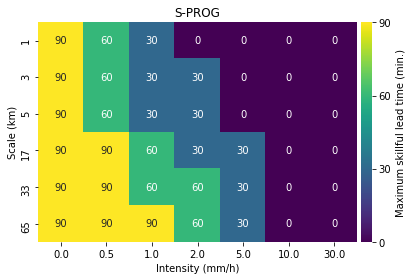

In [129]:
heatmap = sns.heatmap(df, cbar=True, 
                      annot=True, 
                      cmap='viridis', 
                      cbar_kws={'label': 'Maximum skillful lead time (min.)',
                               'ticks': np.arange(0,90+1,30),
                               'pad': 0.01} )
plt.xlabel("Intensity (mm/h)")
plt.ylabel('Scale (km)')
plt.title('S-PROG')
plt.tight_layout()
plt.savefig('figures/fss_leadtimes_sprog')

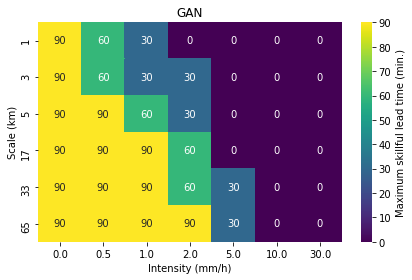

In [130]:
heatmap = sns.heatmap(df_gan, cbar=True, annot=True, cmap='viridis', cbar_kws={'label': 'Maximum skillful lead time (min.)'} )
plt.xlabel("Intensity (mm/h)")
plt.ylabel('Scale (km)')
plt.title('GAN')
plt.tight_layout()
plt.savefig('figures/fss_leadtimes_gan')

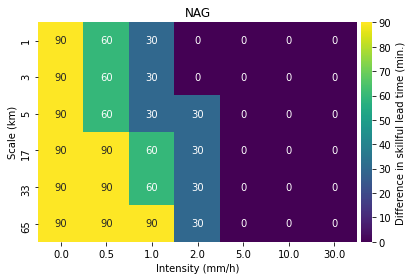

In [131]:
heatmap = sns.heatmap(df_nag, cbar=True, annot=True, 
                      cmap='viridis', 
                      cbar_kws={'label': 'Difference in skillful lead time (min.)',
                               'pad': 0.01} )
plt.xlabel("Intensity (mm/h)")
plt.ylabel('Scale (km)')
plt.title('NAG')
plt.tight_layout()
#plt.savefig('figures/fss_leadtimes_nag')

In [486]:
np.arange(-90,91,30)

array([-90, -60, -30,   0,  30,  60,  90])

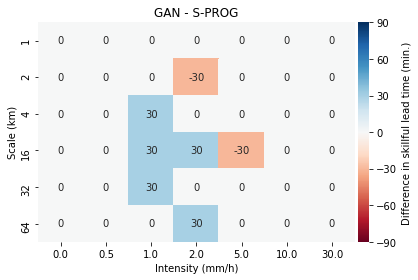

In [493]:
df_diff_gan = df_gan-df
heatmap = sns.heatmap(df_diff_gan, cbar=True, annot=True, 
                      cmap=plt.cm.RdBu,
                      vmax=90,
                      vmin=-90,
                      cbar_kws={'label': 'Difference in skillful lead time (min.)',
                               'pad': 0.01,
                               'ticks': np.arange(-90,90+1,30)} )
plt.xlabel("Intensity (mm/h)")
plt.ylabel('Scale (km)')
plt.title('GAN - S-PROG')
plt.tight_layout()
#plt.savefig('figures/fss_diff_leadtimes_gan')

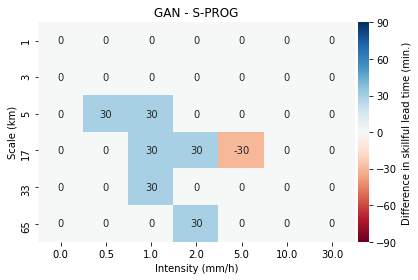

In [134]:
df_diff_gan = df_gan-df
heatmap = sns.heatmap(df_diff_gan, cbar=True, annot=True, 
                      cmap=plt.cm.RdBu,
                      vmax=90,
                      vmin=-90,
                      cbar_kws={'label': 'Difference in skillful lead time (min.)',
                               'pad': 0.01,
                               'ticks': np.arange(-90,90+1,30)} )
plt.xlabel("Intensity (mm/h)")
plt.ylabel('Scale (km)')
plt.title('GAN - S-PROG')
plt.tight_layout()
plt.savefig('figures/fss_diff_leadtimes_gan')

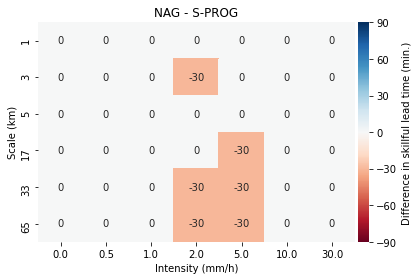

In [135]:
df_diff_nag = df_nag-df
heatmap = sns.heatmap(df_diff_nag, cbar=True, annot=True, 
                      cmap=plt.cm.RdBu,
                      vmax=90,
                      vmin=-90,
                      cbar_kws={'label': 'Difference in skillful lead time (min.)',
                               'pad': 0.01,
                               'ticks': np.arange(-90,90+1,30)} )
plt.xlabel("Intensity (mm/h)")
plt.ylabel('Scale (km)')
plt.title('NAG - S-PROG')
plt.tight_layout()
plt.savefig('figures/fss_diff_leadtimes_nag')

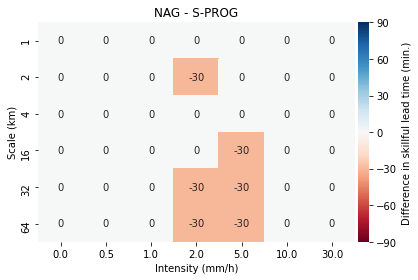

In [495]:
df_diff_nag = df_nag-df
heatmap = sns.heatmap(df_diff_nag, cbar=True, annot=True, 
                      cmap=plt.cm.RdBu,
                      vmax=90,
                      vmin=-90,
                      cbar_kws={'label': 'Difference in skillful lead time (min.)',
                               'pad': 0.01,
                               'ticks': np.arange(-90,90+1,30)} )
plt.xlabel("Intensity (mm/h)")
plt.ylabel('Scale (km)')
plt.title('NAG - S-PROG')
plt.tight_layout()
plt.savefig('figures/fss_diff_leadtimes_nag')

# Categorical score Tables

In [217]:
df_scores_sprog = pd.DataFrame(scores_sprog)
df_scores_sprog = df_scores_sprog.groupby('threshold')
df_scores_sprog = df_scores_sprog.mean()
#df_scores_sprog = df_scores_sprog[['nowcast_method', 'CSI', 'threshold']]
csi_sprog = df_scores_sprog['CSI'].T

In [218]:
df_scores_gan = pd.DataFrame(scores_gan)
df_scores_gan = df_scores_gan.groupby('threshold')
df_scores_gan = df_scores_gan.mean()
#df_scores_sprog = df_scores_sprog[['nowcast_method', 'CSI', 'threshold']]
csi_gan = df_scores_gan['CSI'].T

In [261]:
df_scores_nag = pd.DataFrame(scores_nag)
df_scores_nag = df_scores_nag.groupby('threshold')
df_scores_nag = df_scores_nag.mean()
#df_scores_sprog = df_scores_sprog[['nowcast_method', 'CSI', 'threshold']]
csi_nag = df_scores_nag['CSI'].T

In [ ]:
df_csi = pd.DataFrame([csi_sprog, csi_gan, csi_nag], index=['S-PROG', 'GAN', 'NAG'])
df_csi.columns.name = 'CSI Threshold (mm/h)'
df_csi = df_csi.round(3)
df_csi

In [264]:
print(df_csi.to_latex(bold_rows=True))

\begin{tabular}{lrrrrrrr}
\toprule
\textbf{CSI Threshold (mm/h)} &   0.0  &   0.5  &   1.0  &   2.0  &   5.0  &   10.0 &   30.0 \\
\midrule
\textbf{S-PROG} &  0.487 &  0.350 &  0.280 &  0.189 &  0.073 &  0.022 &  0.003 \\
\textbf{GAN   } &  0.494 &  0.354 &  0.283 &  0.182 &  0.054 &  0.011 &  0.000 \\
\textbf{NAG   } &  0.302 &  0.363 &  0.263 &  0.137 &  0.022 &  0.001 &  0.000 \\
\bottomrule
\end{tabular}



# Performance Diagrams

In [274]:
evaluator_sprog = Evaluator(save_after_n_samples = 1, nowcast_method = 'SPROG_test2')
evaluator_sprog.load_accum_scores()
scores_sprog = evaluator_sprog.get_scores()[0]
scores_sprog_cont = evaluator_sprog.get_scores()[1]
for dic in scores_sprog:
    dic['nowcast_method'] = 'S-PROG'
    
evaluator_gan = Evaluator(save_after_n_samples = 1, nowcast_method = 'model_silver_field_559_test')
evaluator_gan.load_accum_scores()
scores_gan = evaluator_gan.get_scores()[0]
scores_gan_cont = evaluator_gan.get_scores()[1]
for dic in scores_gan:
    dic['nowcast_method'] = 'GAN'
    
evaluator_nag = Evaluator(save_after_n_samples = 1, nowcast_method = 'NAG_test2')
evaluator_nag.load_accum_scores()
scores_nag = evaluator_nag.get_scores()[0]
scores_nag_cont = evaluator_nag.get_scores()[1]
for dic in scores_nag:
    dic['nowcast_method'] = 'NAG'

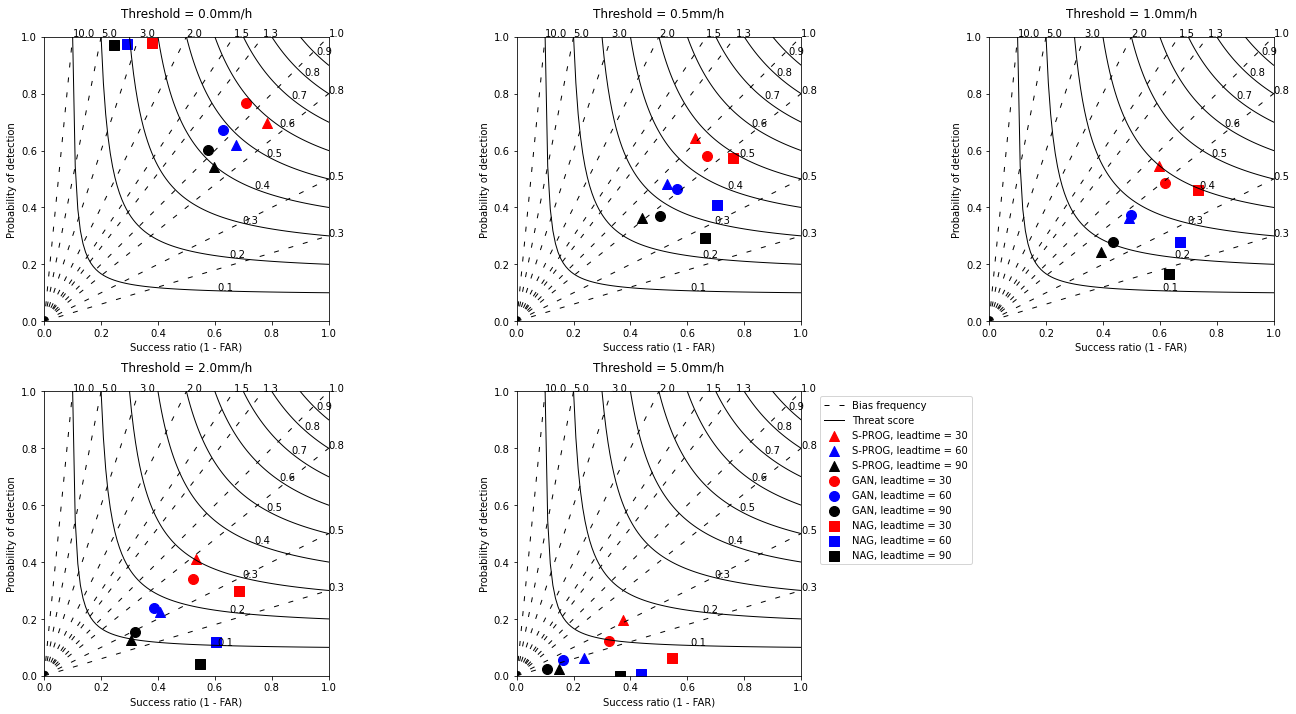

In [286]:
from plotter import performance_diagram

plt.figure(figsize=(18,10))

thresholds = [0, 0.5, 1, 2, 5]

for i,thr in enumerate(thresholds):
    plt.subplot(2,3,i+1)
    thr_gan = [score for score in scores_gan if score['threshold']  == thr ]
    thr_sprog = [score for score in scores_sprog if score['threshold']  == thr]
    thr_nag = [score for score in scores_nag if score['threshold']  == thr]
    #thr_anvil = [score for score in scores_anvil if score['threshold']  == thr]
    
    scores = np.concatenate((thr_sprog, thr_gan, thr_nag))
    legend=False
    if i == len(thresholds)-1:
        legend=True
    performance_diagram(scores, legend)
    plt.title('Threshold = {:.1f}mm/h'.format(thr), y=1.05)
    plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig('figures/perf_diagrams_all')#, bbbox_layout='tight')

# Visualize areas where error occurs

In [6]:
from pysteps_nowcast import get_mask_rtcor

mask = get_mask_rtcor()

In [7]:
from pysteps.verification.detcontscores import det_cont_fct_merge
def get_mean_error(error_maps):
    '''
    Calculate mean error over all 3 lead times
    '''
    error_map = det_cont_fct_merge(error_maps[0], error_maps[1])
    error_map = det_cont_fct_merge(error_map, error_maps[2])
    return error_map

In [8]:
error_maps_sprog = np.load('results/mse_map_SPROG_test.npy', allow_pickle = True)
error_map_sprog = get_mean_error(error_maps_sprog)

error_maps_gan = np.load('results/mse_map_model_silver_field_559_test.npy', allow_pickle = True)
error_map_gan = get_mean_error(error_maps_gan)

error_maps_nag = np.load('results/mse_map_model_quiet_yogurt_535_test.npy', allow_pickle = True)
error_map_nag = get_mean_error(error_maps_nag)

diff_mae = np.abs(error_map_nag['mae'] - error_map_sprog['mae'])
np.sum(diff_mae>0)

431057

In [91]:
def plot_errors(error, quantile=.999, error_type='MSE', set_vmax=True):
    error[~mask] = np.nan

    num_error = np.nan_to_num(error)
    vmax = np.quantile(num_error, quantile)
    if set_vmax:
        # set vmax to highest value of the 99.9 quantile of the three models
        if error_type == 'MSE':
            vmax = 8.17916950623686
        if error_type == 'MAE':
            vmax = 0.2233893659649971
    plot_on_map(error, vmax=vmax, vmin=0.00, colorbar=False, ftype='.h5')
    cbar = plt.colorbar(extend='max', label='{} (mm/h)'.format(error_type))
    plt.axis('off')

In [88]:
gan_error_nonan = gan_error[~np.isnan(gan_error)]
len(gan_error_nonan)

431057

In [ ]:
error_type='MSE'
gan_error = error_map_gan[error_type.lower()]
nag_error = error_map_nag[error_type.lower()]
sprog_error = error_map_sprog[error_type.lower()]
gan_error_nonan = gan_error[~np.isnan(gan_error)].flatten()
nag_error_nonan = nag_error[~np.isnan(nag_error)].flatten()
sprog_error_nonan = sprog_error[~np.isnan(sprog_error)].flatten()


errors = np.concatenate([gan_error_nonan, nag_error_nonan, sprog_error_nonan])
quantile=.999
vmin, vmax = np.quantile(errors, q=[1-quantile, quantile])

vmin, vmax

In [643]:
from plotter import plot_on_map


<ipython-input-44-a87a31416cfc>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
<ipython-input-44-a87a31416cfc>:44: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__
<ipython-input-44-a87a31416cfc>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecation

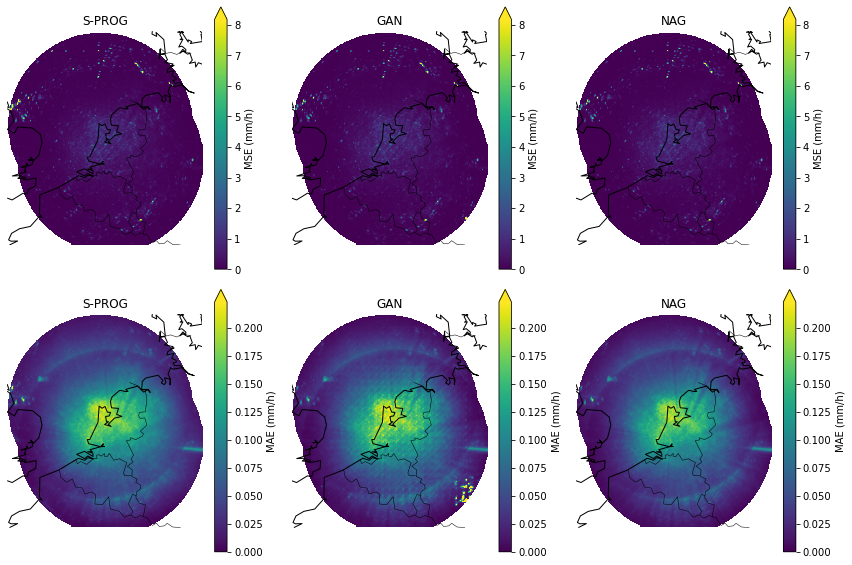

In [103]:
plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plot_errors(error_map_sprog['mse'])
plt.title('S-PROG')

plt.subplot(2,3,2)
 
plot_errors(error_map_gan['mse'])
plt.title('GAN')

plt.subplot(2,3,3)
plot_errors(error_map_nag['mse'])
plt.title('NAG')

plt.subplot(2,3,4)
plot_errors(error_map_sprog['mae'], error_type='MAE')
plt.title('S-PROG')

plt.subplot(2,3,5)
plot_errors(error_map_gan['mae'], error_type='MAE')
plt.title('GAN')

plt.subplot(2,3,6)
plot_errors(error_map_nag['mae'], error_type='MAE')
plt.title('NAG')
plt.tight_layout()
plt.savefig('figures/vis_errors')

-0.4968992479566826 0.9485980767966424
-0.19910063939113756 0.9305194554748591
-0.19958506755701919 0.029970765155624173
-0.008410971537077651 0.03215486010806682


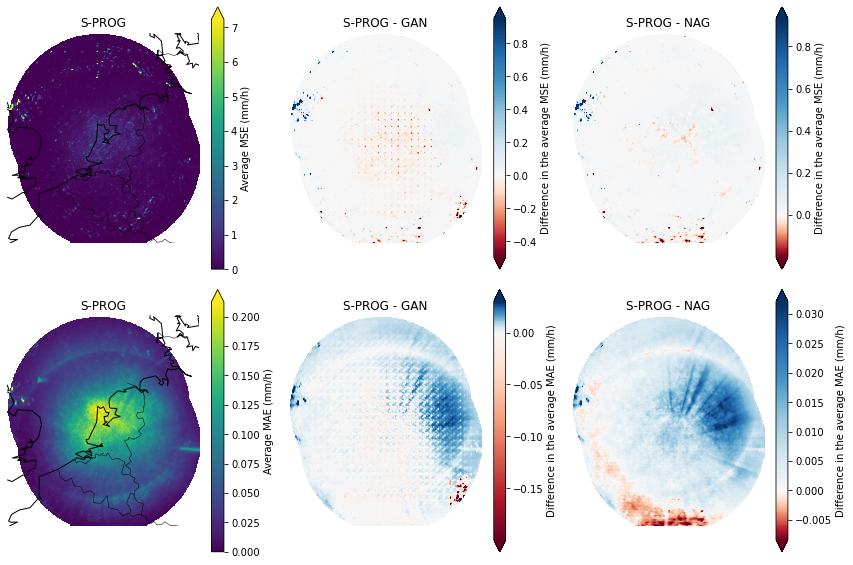

In [706]:
plt.figure(figsize=(12,8))

plt.subplot(2,3,1)
plot_errors(error_map_sprog['mse'], set_vmax= False)
plt.title('S-PROG')

plt.subplot(2,3,2)
 
plot_diff_errors(error_map_gan)
plt.title('S-PROG - GAN')

plt.subplot(2,3,3)
plot_diff_errors(error_map_nag)
plt.title('S-PROG - NAG')

plt.subplot(2,3,4)
plot_errors(error_map_sprog['mae'], error_type='MAE', set_vmax= False)
plt.title('S-PROG')

plt.subplot(2,3,5)
plot_diff_errors(error_map_gan, error_type='MAE')
plt.title('S-PROG - GAN')

plt.subplot(2,3,6)
plot_diff_errors(error_map_nag, error_type='MAE')
plt.title('S-PROG - NAG')
plt.tight_layout()
#plt.savefig('figures/vis_errors_diff')

<ipython-input-44-a87a31416cfc>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
<ipython-input-44-a87a31416cfc>:44: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__
<ipython-input-44-a87a31416cfc>:92: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.imshow(mx, vmin = vmin, vmax=vmax, cmap=cmap, origin='upper',
<ipython-input-44-a87a31416cfc>:41: DeprecationWarning: `np.bool` is a depr

<ipython-input-44-a87a31416cfc>:44: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__
<ipython-input-44-a87a31416cfc>:92: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.imshow(mx, vmin = vmin, vmax=vmax, cmap=cmap, origin='upper',
<ipython-input-44-a87a31416cfc>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
<ipython-input-44-a87a31416cfc>:44: DeprecationWarning: tostring() is depre

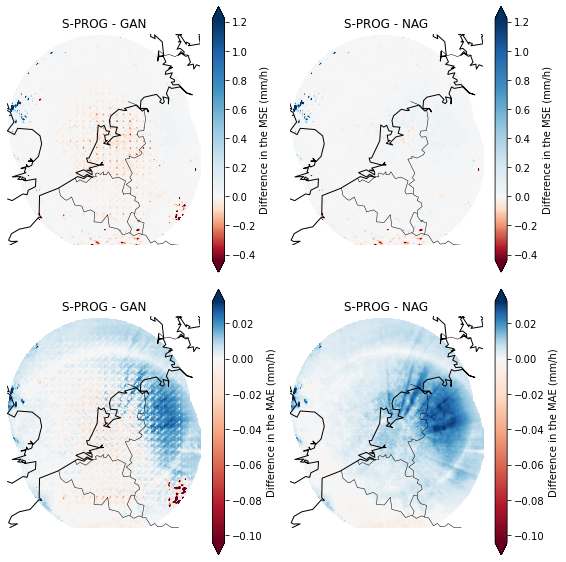

In [143]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plot_diff_errors2(error_map_gan, set_vmax=True, test=True)
plt.title('S-PROG - GAN')

plt.subplot(2,2,2)
plot_diff_errors2(error_map_nag, set_vmax=True, test=True)
plt.title('S-PROG - NAG')

print()
plt.subplot(2,2,3)
plot_diff_errors2(error_map_gan, error_type='MAE', set_vmax=True, test=True)
plt.title('S-PROG - GAN')

plt.subplot(2,2,4)
plot_diff_errors2(error_map_nag, error_type='MAE', set_vmax=True, test=True)
plt.title('S-PROG - NAG')
plt.tight_layout()
plt.savefig('figures/vis_errors_diff')

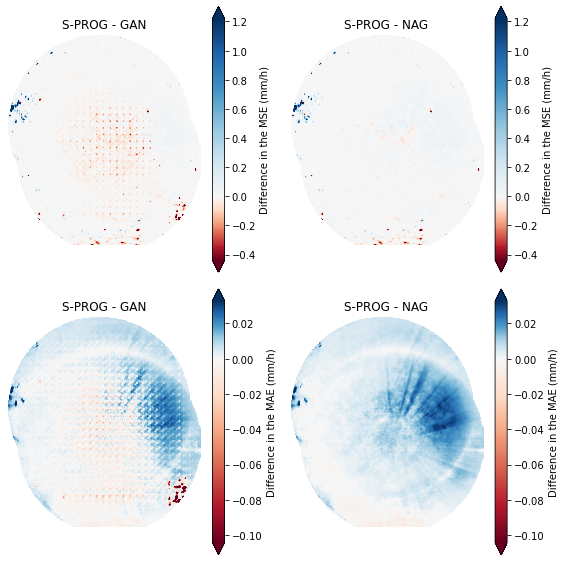

In [104]:
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plot_diff_errors(error_map_gan, set_vmax=True, test=True)
plt.title('S-PROG - GAN')

plt.subplot(2,2,2)
plot_diff_errors(error_map_nag, set_vmax=True, test=True)
plt.title('S-PROG - NAG')

print()
plt.subplot(2,2,3)
plot_diff_errors(error_map_gan, error_type='MAE', set_vmax=True, test=True)
plt.title('S-PROG - GAN')

plt.subplot(2,2,4)
plot_diff_errors(error_map_nag, error_type='MAE', set_vmax=True, test=True)
plt.title('S-PROG - NAG')
plt.tight_layout()
plt.savefig('figures/vis_errors_diff')

In [101]:
def plot_diff_errors(error_dict, quantile=.999, error_type='MSE', set_vmax=False, test=False):
    model_error = error_dict[error_type.lower()]
    sprog_error = error_map_sprog[error_type.lower()]
    
    diff = np.nan_to_num(sprog_error)-np.nan_to_num(model_error)
    vmin, vmax = np.quantile(diff, q=[1-quantile, quantile])

    if set_vmax:
        # set vmax to highest value of the 99.9 quantile of the three models
        if error_type == 'MSE':
            vmax = 0.9485980767966424
            vmin = -0.4968992479566826 
            if test:
                vmax=1.221481186235784
                vmin=-0.438267416532812
        if error_type == 'MAE':
            vmax = 0.03215486010806682
            vmin = - 0.19958506755701919 
            if test:
                vmax=0.03262568269537718
                vmin=-0.10425436037338406
    norm = mcolors.TwoSlopeNorm (vmin=vmin, vmax= vmax, vcenter=0)
    diff[~mask] = np.nan
    cmap=plt.cm.RdBu
    plt.imshow(diff,cmap=cmap, norm=norm)
    cbar = plt.colorbar(extend='both', label='Difference in the {} (mm/h)'.format(error_type))
    plt.axis('off')

In [98]:
error_type='MaE'
model_error = error_map_gan[error_type.lower()]
model_error = model_error[~np.isnan(model_error)].flatten()
sprog_error = error_map_sprog[error_type.lower()]
sprog_error = sprog_error[~np.isnan(sprog_error)].flatten()

diff = sprog_error-np.nan_to_num(model_error)

model_error = error_map_nag[error_type.lower()]
model_error = model_error[~np.isnan(model_error)].flatten()
sprog_error = error_map_sprog[error_type.lower()]
sprog_error = sprog_error[~np.isnan(sprog_error)].flatten()

diff2 = sprog_error-np.nan_to_num(model_error)

errors = np.concatenate([diff.flatten(), diff2.flatten()])
quantile=.999
vmin, vmax = np.quantile(errors, q=[1-quantile, quantile])

vmin, vmax

(-0.10425436037338406, 0.03262568269537718)

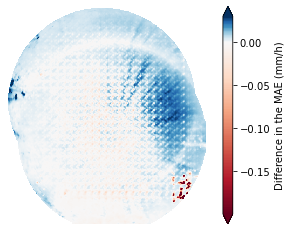

In [136]:
plot_diff_errors(error_map_gan, error_type = 'MAE')

<ipython-input-44-a87a31416cfc>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
<ipython-input-44-a87a31416cfc>:44: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__
<ipython-input-44-a87a31416cfc>:92: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = plt.imshow(mx, vmin = vmin, vmax=vmax, cmap=cmap, origin='upper',


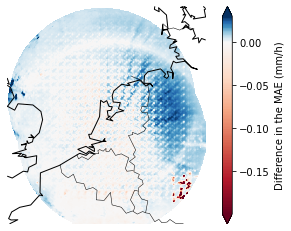

In [141]:
plot_diff_errors2(error_map_gan, error_type = 'MAE')

In [140]:
def plot_diff_errors2(error_dict, quantile=.999, error_type='MSE', set_vmax=False, test=False):
    model_error = error_dict[error_type.lower()]
    sprog_error = error_map_sprog[error_type.lower()]
    
    diff = np.nan_to_num(sprog_error)-np.nan_to_num(model_error)
    vmin, vmax = np.quantile(diff, q=[1-quantile, quantile])

    if set_vmax:
        # set vmax to highest value of the 99.9 quantile of the three models
        if error_type == 'MSE':
            vmax = 0.9485980767966424
            vmin = -0.4968992479566826 
            if test:
                vmax=1.221481186235784
                vmin=-0.438267416532812
        if error_type == 'MAE':
            vmax = 0.03215486010806682
            vmin = - 0.19958506755701919 
            if test:
                vmax=0.03262568269537718
                vmin=-0.10425436037338406
    norm = mcolors.TwoSlopeNorm (vmin=vmin, vmax= vmax, vcenter=0)
    diff[~mask] = np.nan
    cmap=plt.cm.RdBu
    plot_on_map(diff, ftype='.h5', res='l', vmax=vmax, vmin=vmin, norm = norm, cmap= cmap, colorbar =False)
    cbar = plt.colorbar(extend='both', label='Difference in the {} (mm/h)'.format(error_type))
    plt.axis('off')

-0.1995850675570194 0.029970765155624173


(-0.5, 699.5, 764.5, -0.5)

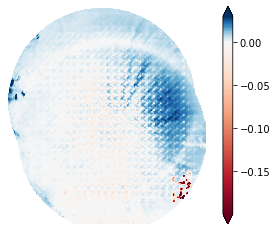

In [11]:
import matplotlib.colors as mcolors


sprog_error = error_map_sprog['mae']
gan_error = error_map_gan['mae']
diff = np.nan_to_num(sprog_error)-np.nan_to_num(gan_error)
vmin, vmax = np.quantile(diff, q=[0.001,.999])

print(vmin, vmax)
norm = mcolors.TwoSlopeNorm (vmin=vmin, vmax= vmax, vcenter=0)

diff[~mask] = np.nan
plt.imshow(diff,cmap=plt.cm.RdBu, norm=norm)
plt.colorbar(extend='both')
plt.axis('off')

-0.1995850675570194 0.029970765155624173


(-0.5, 699.5, 764.5, -0.5)

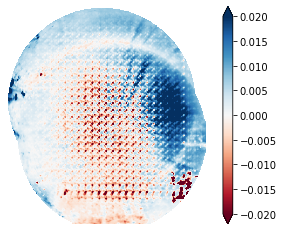

In [17]:
import matplotlib.colors as mcolors


sprog_error = error_map_sprog['mae']
gan_error = error_map_gan['mae']
diff = np.nan_to_num(sprog_error)-np.nan_to_num(gan_error)


print(vmin, vmax)
norm = mcolors.TwoSlopeNorm (vmin=-0.02, vmax= 0.02, vcenter=0)

diff[~mask] = np.nan
plt.imshow(diff,cmap=plt.cm.RdBu, norm=norm)
plt.colorbar(extend='both')
plt.axis('off')

In [44]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import netCDF4
from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap
import config 
from mpl_toolkits.axes_grid1 import ImageGrid
import pysteps

def plot_on_map(rdr, ftype='.nc', res='l', colorbar=True, vmax=None, axis=None,
                vmin=None, norm = None, cmap= None):
    '''
    Plot radar file on top of map.
    rdr: image file
    ftype: file extension, can be either '.nc' or '.h5'
    res: resolution, can be c (crude), l (low), i (intermediate), h (high), f (full) 
    '''
    
    dir_aart = config.dir_aart
    aart_fbase = config.prefix_aart
    proj = Proj("+proj=stere +lat_0=90 +lon_0=0.0 +lat_ts=60.0 +a=6378.137 +b=6356.752 +x_0=0 +y_0=0")
    
    if ftype != '.nc' and ftype !='.h5':
        print('Error: invalid file extension {}, should be .nc or .h5'.format(ftype))
        
     # Add padding to target image
    if ftype =='.nc' and rdr.shape[0] == 384:
        rdr = uncrop_center(rdr)   
    # Remove padding if the image  was padded
    if rdr.shape[0] > 765 and ftype =='.h5':
        rdr = rdr[:765]

        
    # All images are plotted on the same map
    # Get the map from random nc file
    path = dir_aart + '2019/{}201901010000.nc'.format(aart_fbase)
    with netCDF4.Dataset(path, 'r') as ds:
        # Get coordinates of the pixels
        xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
        lon, lat = proj(xx, yy, inverse=True)
        # Plot values on map
        iso_dict = ds['iso_dataset'].__dict__
        min_x = float(iso_dict['min_x'].replace('f', ''))
        min_y = float(iso_dict['min_y'].replace('f', ''))
        max_x = float(iso_dict['max_x'].replace('f', ''))
        max_y = float(iso_dict['max_y'].replace('f', ''))
        
        if ftype == '.nc':
            rain = ds['image1_image_data'][:]
            mask = rain.mask
            
    if  ftype == '.h5':  
        path = config.dir_rtcor +  '2019/01/{}201901010000.h5'.format(config.prefix_rtcor)
        with h5py.File(path, 'r') as f:
                rain = f['image1']['image_data'][:]
                mask = (rain == 65535)

    # Mask the data
    mx = np.ma.masked_array(rdr, mask)
    # Plot the precipitation on map  
    mp = Basemap(projection='stere',
                         lat_0=90,
                         lon_0=0, 
                         lat_ts=60,   
                         llcrnrlon=min_x,   # lower longitude
                         llcrnrlat=min_y,    # lower latitude
                         urcrnrlon=max_x,   # uppper longitude
                         urcrnrlat=max_y,   # uppper latitude
                         resolution=res
                        )
    mp.drawcoastlines()
    mp.drawstates()
    mp.drawcountries()

    xx, yy = mp(lon, lat)

    
#     if not vmin:
#         vmin=-0.00001    
    if not cmap:
        cmap = cm.viridis
    if axis:
        im = axis.imshow(mx, vmin = vmin, vmax=vmax, cmap=cmap, origin='upper', 
           extent=[xx.min(), xx.max(), yy.min(), yy.max()],
                        norm = norm)
        if colorbar:
            axis.colorbar()
        return im
    else:
        im = plt.imshow(mx, vmin = vmin, vmax=vmax, cmap=cmap, origin='upper', 
               extent=[xx.min(), xx.max(), yy.min(), yy.max()], 
                       norm = norm)
        if colorbar:
            plt.colorbar()
        return im


In [47]:
norm = mcolors.TwoSlopeNorm (vmin=-0.05, vmax= 0.05, vcenter=0)


<ipython-input-44-a87a31416cfc>:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xx, yy = np.meshgrid(ds['x'][:], ds['y'][:])
<ipython-input-44-a87a31416cfc>:44: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  iso_dict = ds['iso_dataset'].__dict__


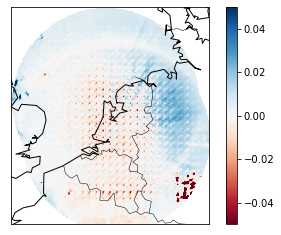

In [48]:
plot_on_map(diff, cmap=plt.cm.RdBu, norm = norm, colorbar=False, ftype='.h5')
plt.colorbar()

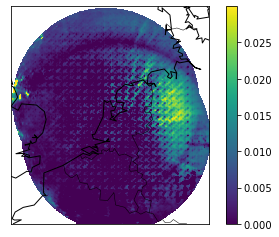

In [35]:
plot_on_map(diff, vmax=vmax, vmin=0.00, colorbar=False, ftype='.h5')
plt.colorbar()

In [33]:
from plotter import plot_on_map
plot_on_map

<function plotter.plot_on_map(rdr, ftype='.nc', res='l', colorbar=True, vmax=None, axis=None, vmin=None, norm=None)>

In [ ]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['white', 'red'])
bounds=[0,5,10]
norm = colors.BoundaryNorm(bounds, cmap.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(zvals, interpolation='nearest', origin='lower',
                    cmap=cmap, norm=norm)

(-0.5, 699.5, 764.5, -0.5)

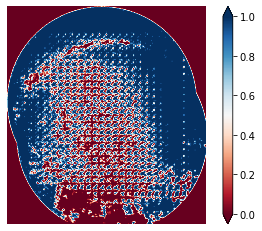

In [14]:
diff[~mask] = np.nan
plt.imshow(diff>0,cmap=plt.cm.RdBu)
plt.colorbar(extend='both')
plt.axis('off')

-0.4968992479566837 0.9485980767966424


(-0.5, 699.5, 764.5, -0.5)

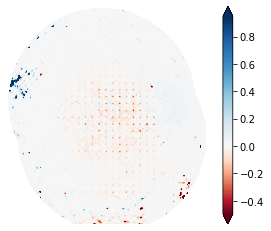

In [568]:
import matplotlib.colors as mcolors


sprog_error = error_map_sprog['mse']
gan_error = error_map_gan['mse']
diff = np.nan_to_num(sprog_error)-np.nan_to_num(gan_error)
vmin, vmax = np.quantile(diff, q=[0.001,.999])

print(vmin, vmax)
norm = mcolors.TwoSlopeNorm (vmin=vmin, vmax= vmax, vcenter=0)

diff[~mask] = np.nan
plt.imshow(diff,cmap=plt.cm.RdBu, norm=norm)
plt.colorbar(extend='both')
plt.axis('off')

-0.008410971537077656 0.03215486010806682


(-0.5, 699.5, 764.5, -0.5)

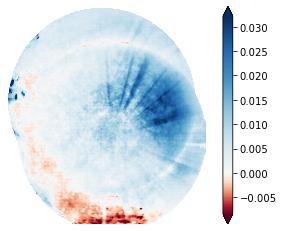

In [558]:
import matplotlib.colors as mcolors


sprog_error = error_map_sprog['mae']
nag_error = error_map_nag['mae']
diff = np.nan_to_num(sprog_error)-np.nan_to_num(nag_error)
diff *= prob[0]
vmin, vmax = np.quantile(diff, q=[0.001,.999])

print(vmin, vmax)
norm = mcolors.TwoSlopeNorm (vmin=vmin, vmax= vmax, vcenter=0)

diff[~mask] = np.nan
plt.imshow(diff,cmap=plt.cm.RdBu, norm=norm)
plt.colorbar(extend='both')
plt.axis('off')

-0.5035350089060276 0.33388115333826157


(-0.5, 699.5, 764.5, -0.5)

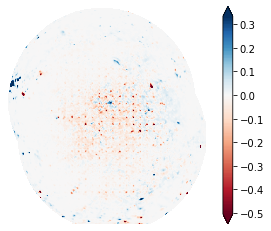

In [500]:
import matplotlib.colors as mcolors


sprog_error = mse_map_sprog[0]['mse']
gan_error = mse_map_gan[0]['mse']
diff = np.nan_to_num(sprog_error)-np.nan_to_num(gan_error)
vmin, vmax = np.quantile(diff, q=[0.001,.999])

print(vmin, vmax)
norm = mcolors.TwoSlopeNorm (vmin=vmin, vmax= vmax, vcenter=0)

diff[~mask] = np.nan
plt.imshow(diff,cmap=plt.cm.RdBu, norm=norm)
plt.colorbar(extend='both')
plt.axis('off')